###  데이터 전처리하기

In [1]:
# 주의! ray를 tensorflow보다 먼저 import하면 오류가 발생할 수 있습니다
import io, json, os, math

import tensorflow as tf
from tensorflow.keras.layers import Add, Concatenate, Lambda
from tensorflow.keras.layers import Input, Conv2D, ReLU, MaxPool2D
from tensorflow.keras.layers import UpSampling2D, ZeroPadding2D
from tensorflow.keras.layers import BatchNormalization
import ray

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

PROJECT_PATH = os.getenv('HOME') + '/aiffel/mpii'
IMAGE_PATH = os.path.join(PROJECT_PATH, 'images')
# MODEL_PATH = os.path.join(PROJECT_PATH, 'models')
MODEL_PATH = os.path.join(PROJECT_PATH, 'trained')
TFRECORD_PATH = os.path.join(PROJECT_PATH, 'tfrecords_mpii')
TRAIN_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'train.json')
VALID_JSON = os.path.join(PROJECT_PATH, 'mpii_human_pose_v1_u12_2', 'validation.json')

Matplotlib is building the font cache; this may take a moment.


#### json 파싱하기
- `train.json`, `validation.json` : 이미지에 담겨 있는 사람들의 pose keypoint(Pose Estimation을 위한 label) 정보들을 가지고 있음

In [2]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    json_formatted_str = json.dumps(train_annos[0], indent=2)
    print(json_formatted_str)

{
  "joints_vis": [
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1,
    1
  ],
  "joints": [
    [
      620.0,
      394.0
    ],
    [
      616.0,
      269.0
    ],
    [
      573.0,
      185.0
    ],
    [
      647.0,
      188.0
    ],
    [
      661.0,
      221.0
    ],
    [
      656.0,
      231.0
    ],
    [
      610.0,
      187.0
    ],
    [
      647.0,
      176.0
    ],
    [
      637.0201,
      189.8183
    ],
    [
      695.9799,
      108.1817
    ],
    [
      606.0,
      217.0
    ],
    [
      553.0,
      161.0
    ],
    [
      601.0,
      167.0
    ],
    [
      692.0,
      185.0
    ],
    [
      693.0,
      240.0
    ],
    [
      688.0,
      313.0
    ]
  ],
  "image": "015601864.jpg",
  "scale": 3.021046,
  "center": [
    594.0,
    257.0
  ]
}


- `joints` 가 우리가 label 로 사용할 keypoint 의 label
  - 0 - 오른쪽 발목
    1 - 오른쪽 무릎
    2 - 오른쪽 엉덩이
    3 - 왼쪽 엉덩이
    4 - 왼쪽 무릎
    5 - 왼쪽 발목
    6 - 골반
    7 - 가슴(흉부)
    8 - 목
    9 - 머리 위
    10 - 오른쪽 손목
    11 - 오른쪽 팔꿈치
    12 - 오른쪽 어깨
    13 - 왼쪽 어깨
    14 - 왼쪽 팔꿈치
    15 - 왼쪽 손목
- `scale`과 `center`는 사람 몸의 크기와 중심점
- 이미지 형상과 사람의 포즈에 따라 모든 label 이 이미지에 나타나지 않기 때문에, `joints_vis` 를 이용해서 실제로 사용할 수 있는 keypoint 인지 나타냄
- MPII 의 경우 1 (visible) / 0(non) 으로만 나누어지기 때문에 조금 더 쉽게 사용
- coco 의 경우 2 / 1 / 0 으로 표현해서 occlusion 상황까지 label

- json annotation 을 파싱하는 함수

In [3]:
def parse_one_annotation(anno, image_dir):
    filename = anno['image']
    joints = anno['joints']
    joints_visibility = anno['joints_vis']
    annotation = {
        'filename': filename,
        'filepath': os.path.join(image_dir, filename),
        'joints_visibility': joints_visibility,
        'joints': joints,
        'center': anno['center'],
        'scale' : anno['scale']
    }
    return annotation

In [4]:
with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    test = parse_one_annotation(train_annos[0], IMAGE_PATH)
    print(test)

{'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}


### TFRecord 파일 만들기
- 실제 프로젝트에서는 튜토리얼 데이터셋보다 훨씬 큰 크기의 데이터를 다룸
- unless you are using tf.data and reading data is still the bottleneck to training.
- gpu 의 연산 속도보다 HDD I/O 가 느리기 때문에 병목 현상이 발생
- 대단위 프로젝트 실험에서 효율성이 떨어짐

**[tf.data API로 성능 향상하기](https://www.tensorflow.org/guide/data_performance?hl=ko)**  
- data read(또는 prefetch) 또는 데이터 변환 단계에서 gpu 학습과 병렬적으로 수행되도록 prefetch를 적용해야 함
- 수행방법은 tf.data의 map 함수를 이용하고 cache 에 저장해두는 방법 -> TFRecord를 사용하여 해결
- TFRecord : binary record sequence 를 저장하기 위한 형식

In [5]:
def generate_tfexample(anno):

    # byte 인코딩을 위한 함수
    def _bytes_feature(value):
        if isinstance(value, type(tf.constant(0))):
            value = value.numpy()
        return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

    filename = anno['filename']
    filepath = anno['filepath']
    with open(filepath, 'rb') as image_file:
        content = image_file.read()

    image = Image.open(filepath)
    if image.format != 'JPEG' or image.mode != 'RGB':
        image_rgb = image.convert('RGB')
        with io.BytesIO() as output:
            image_rgb.save(output, format="JPEG", quality=95)
            content = output.getvalue()

    width, height = image.size
    depth = 3

    c_x = int(anno['center'][0])
    c_y = int(anno['center'][1])
    scale = anno['scale']

    x = [
        int(joint[0]) if joint[0] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]
    y = [
        int(joint[1]) if joint[1] >= 0 else int(joint[0]) 
        for joint in anno['joints']
    ]

    v = [0 if joint_v == 0 else 2 for joint_v in anno['joints_visibility']]

    feature = {
        'image/height':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[height])),
        'image/width':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[width])),
        'image/depth':
        tf.train.Feature(int64_list=tf.train.Int64List(value=[depth])),
        'image/object/parts/x':
        tf.train.Feature(int64_list=tf.train.Int64List(value=x)),
        'image/object/parts/y':
        tf.train.Feature(int64_list=tf.train.Int64List(value=y)),
        'image/object/center/x': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_x])),
        'image/object/center/y': 
        tf.train.Feature(int64_list=tf.train.Int64List(value=[c_y])),
        'image/object/scale':
        tf.train.Feature(float_list=tf.train.FloatList(value=[scale])),
        'image/object/parts/v':
        tf.train.Feature(int64_list=tf.train.Int64List(value=v)),
        'image/encoded':
        _bytes_feature(content),
        'image/filename':
        _bytes_feature(filename.encode())
    }

    return tf.train.Example(features=tf.train.Features(feature=feature))

In [6]:
def chunkify(l, n):
    # 전체 데이터 l을 n그룹으로 나눔
    # -> n개의 TFRecord 파일을 만듦 (n개로 shard 함)
    size = len(l) // n
    start = 0
    results = []
    for i in range(n):
        results.append(l[start:start + size])
        start += size
    return results

- 너무 작은 파일로 많이 나누면 학습 중간에 너무 잦은 입출력이 요구
- 너무 큰 파일로 적게 나누면 입출력마다 걸리는 시간이 길어짐
- 입출력에 걸리는 시간이 GPU의 계산 시간보다 길어지면 그만큼 손해가 됨

**annotation 을 shard 로 나눠야 하는 이유**  
- I/O 병목을 피하기 위해 입력 파일을 여러개로 나눈 뒤, 병렬적으로 prefetch 하는 것이 학습 속도를 빠르게 함
- 튜토리얼에서는 경험상 데이터를 읽는 호스트보다 최소 10 배 많은 파일을 보유하는 것이 좋음
- 동시에 각 파일은 I / O 프리 페치의 이점을 누릴 수 있도록 충분히 커야함
- 최소 10MB 이상, 이상적으로는 100MB 이상

In [7]:
test_chunks = chunkify([0] * 1000, 64)
print(test_chunks)
print(len(test_chunks))
print(len(test_chunks[0]))

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0,

In [8]:
@ray.remote
def build_single_tfrecord(chunk, path):
    print('start to build tf records for ' + path)

    with tf.io.TFRecordWriter(path) as writer:
        for anno in chunk:
            tf_example = generate_tfexample(anno)
            writer.write(tf_example.SerializeToString())

    print('finished building tf records for ' + path)

[`@ray.remote`](https://www.ray.io/) : 병렬 처리용

In [9]:
def build_tf_records(annotations, total_shards, split):
    chunks = chunkify(annotations, total_shards)
    futures = [
        build_single_tfrecord.remote(
            chunk, '{}/{}_{}_of_{}.tfrecords'.format(
                TFRECORD_PATH,
                split,
                str(i + 1).zfill(4),
                str(total_shards).zfill(4),
            )) for i, chunk in enumerate(chunks)
    ]
    ray.get(futures)

### Ray
[What is Ray?](https://docs.ray.io/en/latest/)  

```
import ray
ray.init()

@ray.remote
def f(x):
    return x * x

futures = [f.remote(i) for i in range(4)]
print(ray.get(futures)) # [0, 1, 4, 9]

@ray.remote
class Counter(object):
    def __init__(self):
        self.n = 0

    def increment(self):
        self.n += 1

    def read(self):
        return self.n

counters = [Counter.remote() for i in range(4)]
[c.increment.remote() for c in counters]
futures = [c.read.remote() for c in counters]
print(ray.get(futures)) # [1, 1, 1, 1]

```
- 함수나 클래스에 `@ray.remote` 데코레이터를 붙이고 `some_function.remote()`형식으로 함수를 만듦
- 클래스의 경우에는 메서드를 호출할 때 `remote()`를 이용
- 함수나 메서드는 이 시점에 실행되는 것이 아니라 생성만 됨
- `ray.get()`을 통해 실행이 되는 구조

**[multiprocessing 과 ray 의 사용상 차이점](https://modulabs.co.kr/blog/ray-multiprocessing-python)**  
- MP 는 병렬화를 위해 추상적 구조를 새로 설계해야 하지만 ray 는 쓰던 코드에서 거의 수정 없이 병렬화 할 수 있음

In [10]:
num_train_shards = 64
num_val_shards = 8

ray.init()

print('Start to parse annotations.')
if not os.path.exists(TFRECORD_PATH):
    os.makedirs(TFRECORD_PATH)

with open(TRAIN_JSON) as train_json:
    train_annos = json.load(train_json)
    train_annotations = [
        parse_one_annotation(anno, IMAGE_PATH)
        for anno in train_annos
    ]
    print('First train annotation: ', train_annotations[0])

with open(VALID_JSON) as val_json:
    val_annos = json.load(val_json)
    val_annotations = [
        parse_one_annotation(anno, IMAGE_PATH) 
        for anno in val_annos
    ]
    print('First val annotation: ', val_annotations[0])
    
print('Start to build TF Records.')
build_tf_records(train_annotations, num_train_shards, 'train')
build_tf_records(val_annotations, num_val_shards, 'val')

print('Successfully wrote {} annotations to TF Records.'.format(
    len(train_annotations) + len(val_annotations)))

2025-03-17 12:05:39,124	WARNING services.py:1729 -- WARNING: The object store is using /tmp instead of /dev/shm because /dev/shm has only 67108864 bytes available. This will harm performance! You may be able to free up space by deleting files in /dev/shm. If you are inside a Docker container, you can increase /dev/shm size by passing '--shm-size=3.89gb' to 'docker run' (or add it to the run_options list in a Ray cluster config). Make sure to set this to more than 30% of available RAM.


Start to parse annotations.
First train annotation:  {'filename': '015601864.jpg', 'filepath': '/aiffel/aiffel/mpii/images/015601864.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[620.0, 394.0], [616.0, 269.0], [573.0, 185.0], [647.0, 188.0], [661.0, 221.0], [656.0, 231.0], [610.0, 187.0], [647.0, 176.0], [637.0201, 189.8183], [695.9799, 108.1817], [606.0, 217.0], [553.0, 161.0], [601.0, 167.0], [692.0, 185.0], [693.0, 240.0], [688.0, 313.0]], 'center': [594.0, 257.0], 'scale': 3.021046}
First val annotation:  {'filename': '005808361.jpg', 'filepath': '/aiffel/aiffel/mpii/images/005808361.jpg', 'joints_visibility': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 'joints': [[804.0, 711.0], [816.0, 510.0], [908.0, 438.0], [1040.0, 454.0], [906.0, 528.0], [883.0, 707.0], [974.0, 446.0], [985.0, 253.0], [982.7591, 235.9694], [962.2409, 80.0306], [869.0, 214.0], [798.0, 340.0], [902.0, 253.0], [1067.0, 253.0], [1167.0, 353.0], [1142.0, 478.0]], 'c

(build_single_tfrecord pid=134) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0025_of_0064.tfrecords
(build_single_tfrecord pid=134) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=135) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0026_of_0064.tfrecords
(build_single_tfrecord pid=135) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0029_of_0064.tfrecords
(build_single_tfrecord pid=136) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0027_of_0064.tfrecords
(build_single_tfrecord pid=136) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0030_of_0064.tfrecords
(build_single_tfrecord pid=134) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0028_of_0064.tfrecords
(build_single_tfrecord pid=134) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_003

(build_single_tfrecord pid=136) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0055_of_0064.tfrecords
(build_single_tfrecord pid=136) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=134) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0056_of_0064.tfrecords
(build_single_tfrecord pid=134) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0059_of_0064.tfrecords
(build_single_tfrecord pid=135) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0057_of_0064.tfrecords
(build_single_tfrecord pid=135) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0060_of_0064.tfrecords
(build_single_tfrecord pid=136) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_0058_of_0064.tfrecords
(build_single_tfrecord pid=136) start to build tf records for /aiffel/aiffel/mpii/tfrecords_mpii/train_006

### data label 로 만들기
- TFRecord로 저장된 데이터를 모델 학습에 필요한 데이터로 바꿔줄 함수가 필요
- tensorflow에서 이미 제공해주는 함수를 사용
- 주의할 점은 TFRecord가 직렬화된 데이터이기 때문에 만들 때 데이터 순서와 읽어올 때 데이터 순서가 같아야 함
- 데이터의 형식도 동일해야 함

In [11]:
def parse_tfexample(example):
    image_feature_description = {
        'image/height': tf.io.FixedLenFeature([], tf.int64),
        'image/width': tf.io.FixedLenFeature([], tf.int64),
        'image/depth': tf.io.FixedLenFeature([], tf.int64),
        'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
        'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
        'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
        'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
        'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
        'image/encoded': tf.io.FixedLenFeature([], tf.string),
        'image/filename': tf.io.FixedLenFeature([], tf.string),
    }
    return tf.io.parse_single_example(example, image_feature_description)

In [12]:
def crop_roi(image, features, margin=0.2):
    img_shape = tf.shape(image)
    img_height = img_shape[0]
    img_width = img_shape[1]
    img_depth = img_shape[2]

    keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
    keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
    center_x = features['image/object/center/x']
    center_y = features['image/object/center/y']
    body_height = features['image/object/scale'] * 200.0

    # keypoint 중 유효한값(visible = 1) 만 사용합니다.
    masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
    masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)

    # min, max 값을 찾습니다.
    keypoint_xmin = tf.reduce_min(masked_keypoint_x)
    keypoint_xmax = tf.reduce_max(masked_keypoint_x)
    keypoint_ymin = tf.reduce_min(masked_keypoint_y)
    keypoint_ymax = tf.reduce_max(masked_keypoint_y)

    # 높이 값을 이용해서 x, y 위치를 재조정 합니다. 박스를 정사각형으로 사용하기 위해 아래와 같이 사용합니다.
    xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
    xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
    ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
    ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)

    # 이미지 크기를 벗어나는 점을 재조정 해줍니다.
    effective_xmin = xmin if xmin > 0 else 0
    effective_ymin = ymin if ymin > 0 else 0
    effective_xmax = xmax if xmax < img_width else img_width
    effective_ymax = ymax if ymax < img_height else img_height
    effective_height = effective_ymax - effective_ymin
    effective_width = effective_xmax - effective_xmin

    image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
    new_shape = tf.shape(image)
    new_height = new_shape[0]
    new_width = new_shape[1]

    effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
    effective_keypoint_y = (keypoint_y - effective_ymin) / new_height

    return image, effective_keypoint_x, effective_keypoint_y

(build_single_tfrecord pid=136) finished building tf records for /aiffel/aiffel/mpii/tfrecords_mpii/val_0008_of_0008.tfrecords


![heatmap](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-2.max-800x600.png)  
- (x, y) 좌표로 되어있는 keypoint 를 heatmap 으로 변경
- 하나의 점에만 표시 되어있는 정보를 좌표 근처 여러 지점에 확률 분포 형태로 학습시키면 결과가 더 좋음
- 확률 분포로는 2차원 가우시안 분포를 사용

In [2]:
def generate_2d_guassian(height, width, y0, x0, visibility=2, sigma=1, scale=12):
    heatmap = tf.zeros((height, width))

    xmin = x0 - 3 * sigma
    ymin = y0 - 3 * sigma
    xmax = x0 + 3 * sigma
    ymax = y0 + 3 * sigma
    
    if xmin >= width or ymin >= height or xmax < 0 or ymax < 0 or visibility == 0:
        return heatmap

    size = 6 * sigma + 1
    x, y = tf.meshgrid(tf.range(0, 6 * sigma + 1, 1), tf.range(0, 6 * sigma + 1, 1), indexing='xy')

    center_x = size // 2
    center_y = size // 2

    gaussian_patch = tf.cast(tf.math.exp(
        -(tf.math.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale,
                             dtype=tf.float32)

    patch_xmin = tf.math.maximum(0, -xmin)
    patch_ymin = tf.math.maximum(0, -ymin)
    patch_xmax = tf.math.minimum(xmax, width) - xmin
    patch_ymax = tf.math.minimum(ymax, height) - ymin

    heatmap_xmin = tf.math.maximum(0, xmin)
    heatmap_ymin = tf.math.maximum(0, ymin)
    heatmap_xmax = tf.math.minimum(xmax, width)
    heatmap_ymax = tf.math.minimum(ymax, height)

    indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
    updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

    count = 0

    for j in tf.range(patch_ymin, patch_ymax):
        for i in tf.range(patch_xmin, patch_xmax):
            indices = indices.write(count, [heatmap_ymin + j, heatmap_xmin + i])
            updates = updates.write(count, gaussian_patch[j][i])
            count += 1

    heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

    return heatmap

def make_heatmaps(features, keypoint_x, keypoint_y, heatmap_shape):
    v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
    x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
    y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)

    num_heatmap = heatmap_shape[2]
    heatmap_array = tf.TensorArray(tf.float32, 16)

    for i in range(num_heatmap):
        gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
        heatmap_array = heatmap_array.write(i, gaussian)

    heatmaps = heatmap_array.stack()
    heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0])  # change to (64, 64, 16)

    return heatmaps

In [3]:
class Preprocessor(object):
    def __init__(self,
                 image_shape=(256, 256, 3),
                 heatmap_shape=(64, 64, 16),
                 is_train=False):
        self.is_train = is_train
        self.image_shape = image_shape
        self.heatmap_shape = heatmap_shape

    def __call__(self, example):
        features = self.parse_tfexample(example)
        image = tf.io.decode_jpeg(features['image/encoded'])

        if self.is_train:
            random_margin = tf.random.uniform([1], 0.1, 0.3)[0]
            image, keypoint_x, keypoint_y = self.crop_roi(image, features, margin=random_margin)
            image = tf.image.resize(image, self.image_shape[0:2])
        else:
            image, keypoint_x, keypoint_y = self.crop_roi(image, features)
            image = tf.image.resize(image, self.image_shape[0:2])

        image = tf.cast(image, tf.float32) / 127.5 - 1
        heatmaps = self.make_heatmaps(features, keypoint_x, keypoint_y, self.heatmap_shape)

        return image, heatmaps

        
    def crop_roi(self, image, features, margin=0.2):
        img_shape = tf.shape(image)
        img_height = img_shape[0]
        img_width = img_shape[1]
        img_depth = img_shape[2]

        keypoint_x = tf.cast(tf.sparse.to_dense(features['image/object/parts/x']), dtype=tf.int32)
        keypoint_y = tf.cast(tf.sparse.to_dense(features['image/object/parts/y']), dtype=tf.int32)
        center_x = features['image/object/center/x']
        center_y = features['image/object/center/y']
        body_height = features['image/object/scale'] * 200.0
        
        masked_keypoint_x = tf.boolean_mask(keypoint_x, keypoint_x > 0)
        masked_keypoint_y = tf.boolean_mask(keypoint_y, keypoint_y > 0)
        
        keypoint_xmin = tf.reduce_min(masked_keypoint_x)
        keypoint_xmax = tf.reduce_max(masked_keypoint_x)
        keypoint_ymin = tf.reduce_min(masked_keypoint_y)
        keypoint_ymax = tf.reduce_max(masked_keypoint_y)
        
        xmin = keypoint_xmin - tf.cast(body_height * margin, dtype=tf.int32)
        xmax = keypoint_xmax + tf.cast(body_height * margin, dtype=tf.int32)
        ymin = keypoint_ymin - tf.cast(body_height * margin, dtype=tf.int32)
        ymax = keypoint_ymax + tf.cast(body_height * margin, dtype=tf.int32)
        
        effective_xmin = xmin if xmin > 0 else 0
        effective_ymin = ymin if ymin > 0 else 0
        effective_xmax = xmax if xmax < img_width else img_width
        effective_ymax = ymax if ymax < img_height else img_height
        effective_height = effective_ymax - effective_ymin
        effective_width = effective_xmax - effective_xmin

        image = image[effective_ymin:effective_ymax, effective_xmin:effective_xmax, :]
        new_shape = tf.shape(image)
        new_height = new_shape[0]
        new_width = new_shape[1]
        
        effective_keypoint_x = (keypoint_x - effective_xmin) / new_width
        effective_keypoint_y = (keypoint_y - effective_ymin) / new_height
        
        return image, effective_keypoint_x, effective_keypoint_y
        
    
    def generate_2d_guassian(self, height, width, y0, x0, visibility=2, sigma=1, scale=12):
        
        heatmap = tf.zeros((height, width))

        xmin = x0 - 3 * sigma
        ymin = y0 - 3 * sigma
        xmax = x0 + 3 * sigma
        ymax = y0 + 3 * sigma

        if xmin >= width or ymin >= height or xmax < 0 or ymax <0 or visibility == 0:
            return heatmap

        size = 6 * sigma + 1
        x, y = tf.meshgrid(tf.range(0, 6*sigma+1, 1), tf.range(0, 6*sigma+1, 1), indexing='xy')

        center_x = size // 2
        center_y = size // 2

        gaussian_patch = tf.cast(tf.math.exp(-(tf.square(x - center_x) + tf.math.square(y - center_y)) / (tf.math.square(sigma) * 2)) * scale, dtype=tf.float32)

        patch_xmin = tf.math.maximum(0, -xmin)
        patch_ymin = tf.math.maximum(0, -ymin)
        patch_xmax = tf.math.minimum(xmax, width) - xmin
        patch_ymax = tf.math.minimum(ymax, height) - ymin

        heatmap_xmin = tf.math.maximum(0, xmin)
        heatmap_ymin = tf.math.maximum(0, ymin)
        heatmap_xmax = tf.math.minimum(xmax, width)
        heatmap_ymax = tf.math.minimum(ymax, height)

        indices = tf.TensorArray(tf.int32, 1, dynamic_size=True)
        updates = tf.TensorArray(tf.float32, 1, dynamic_size=True)

        count = 0

        for j in tf.range(patch_ymin, patch_ymax):
            for i in tf.range(patch_xmin, patch_xmax):
                indices = indices.write(count, [heatmap_ymin+j, heatmap_xmin+i])
                updates = updates.write(count, gaussian_patch[j][i])
                count += 1
                
        heatmap = tf.tensor_scatter_nd_update(heatmap, indices.stack(), updates.stack())

        return heatmap


    def make_heatmaps(self, features, keypoint_x, keypoint_y, heatmap_shape):
        v = tf.cast(tf.sparse.to_dense(features['image/object/parts/v']), dtype=tf.float32)
        x = tf.cast(tf.math.round(keypoint_x * heatmap_shape[0]), dtype=tf.int32)
        y = tf.cast(tf.math.round(keypoint_y * heatmap_shape[1]), dtype=tf.int32)
        
        num_heatmap = heatmap_shape[2]
        heatmap_array = tf.TensorArray(tf.float32, 16)

        for i in range(num_heatmap):
            gaussian = self.generate_2d_guassian(heatmap_shape[1], heatmap_shape[0], y[i], x[i], v[i])
            heatmap_array = heatmap_array.write(i, gaussian)
        
        heatmaps = heatmap_array.stack()
        heatmaps = tf.transpose(heatmaps, perm=[1, 2, 0]) # change to (64, 64, 16)
        
        return heatmaps

    def parse_tfexample(self, example):
        image_feature_description = {
            'image/height': tf.io.FixedLenFeature([], tf.int64),
            'image/width': tf.io.FixedLenFeature([], tf.int64),
            'image/depth': tf.io.FixedLenFeature([], tf.int64),
            'image/object/parts/x': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/y': tf.io.VarLenFeature(tf.int64),
            'image/object/parts/v': tf.io.VarLenFeature(tf.int64),
            'image/object/center/x': tf.io.FixedLenFeature([], tf.int64),
            'image/object/center/y': tf.io.FixedLenFeature([], tf.int64),
            'image/object/scale': tf.io.FixedLenFeature([], tf.float32),
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/filename': tf.io.FixedLenFeature([], tf.string),
        }
        return tf.io.parse_single_example(example,
                                          image_feature_description)

### 모델 학습
#### Hourglass 모델
![model](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-4.max-800x600.png)  
- residual block 의 2가지 타입
  - 3x3-3x3 basic block, 1x1-3x3-1x1 bottleneck block

In [4]:
def BottleneckBlock(inputs, filters, strides=1, downsample=False, name=None):
    identity = inputs
    if downsample:
        identity = Conv2D(
            filters=filters,
            kernel_size=1,
            strides=strides,
            padding='same',
            kernel_initializer='he_normal')(inputs)

    x = BatchNormalization(momentum=0.9)(inputs)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters // 2,
        kernel_size=3,
        strides=strides,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(x)

    x = Add()([identity, x])
    return x

In [5]:
def HourglassModule(inputs, order, filters, num_residual):
    
    up1 = BottleneckBlock(inputs, filters, downsample=False)
    for i in range(num_residual):
        up1 = BottleneckBlock(up1, filters, downsample=False)

    low1 = MaxPool2D(pool_size=2, strides=2)(inputs)
    for i in range(num_residual):
        low1 = BottleneckBlock(low1, filters, downsample=False)

    low2 = low1
    if order > 1:
        # 재귀 함수를 이용
        low2 = HourglassModule(low1, order - 1, filters, num_residual)
    else:
        for i in range(num_residual):
            low2 = BottleneckBlock(low2, filters, downsample=False)

    low3 = low2
    for i in range(num_residual):
        low3 = BottleneckBlock(low3, filters, downsample=False)

    up2 = UpSampling2D(size=2)(low3)

    return up2 + up1

- intermediate output을 위한 linear layer
![https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-10-P-5.png](https://d3s0tskafalll9.cloudfront.net/media/original_images/GC-10-P-5.png)  
- 여러 모듈을 쌓을수록 모델이 깊어지는 만큼 학습이 어려워, 저자들은 Intermediate supervision을 적용
- 모듈 사이의 네트워크의 파란 박스는 모델 중간에 계산되는 히트맵 결과를 출력하는 convolution layer
- 이 히트맵과 ground truth의 차이를 intermediate loss (auxilary loss) 로 계산
- [stacked hourglass module은 보다 정교한 결과를 도출](https://modulabs.co.kr/blog/stacked-hourglass-networks-pose-estimation)

In [6]:
def LinearLayer(inputs, filters):
    x = Conv2D(
        filters=filters,
        kernel_size=1,
        strides=1,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    return x

![https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-6.max-800x600.png](https://d3s0tskafalll9.cloudfront.net/media/images/GC-10-P-6.max-800x600.png)  
- stacked 되는 hourglass 층 사이사이에 LinearLayer 를 삽입하고 중간 loss 를 계산

In [7]:
def StackedHourglassNetwork(
        input_shape=(256, 256, 3), 
        num_stack=4, 
        num_residual=1,
        num_heatmap=16):
    
    inputs = Input(shape=input_shape)

    x = Conv2D(
        filters=64,
        kernel_size=7,
        strides=2,
        padding='same',
        kernel_initializer='he_normal')(inputs)
    x = BatchNormalization(momentum=0.9)(x)
    x = ReLU()(x)
    x = BottleneckBlock(x, 128, downsample=True)
    x = MaxPool2D(pool_size=2, strides=2)(x)
    x = BottleneckBlock(x, 128, downsample=False)
    x = BottleneckBlock(x, 256, downsample=True)

    ys = []
    for i in range(num_stack):
        x = HourglassModule(x, order=4, filters=256, num_residual=num_residual)
        for i in range(num_residual):
            x = BottleneckBlock(x, 256, downsample=False)

        x = LinearLayer(x, 256)

        y = Conv2D(
            filters=num_heatmap,
            kernel_size=1,
            strides=1,
            padding='same',
            kernel_initializer='he_normal')(x)
        ys.append(y)

        if i < num_stack - 1:
            y_intermediate_1 = Conv2D(filters=256, kernel_size=1, strides=1)(x)
            y_intermediate_2 = Conv2D(filters=256, kernel_size=1, strides=1)(y)
            x = Add()([y_intermediate_1, y_intermediate_2])

    return tf.keras.Model(inputs, ys, name='stacked_hourglass')

### 학습 엔진
#### [GPU가 여러개인 환경](https://www.tensorflow.org/tutorials/distribute/keras)
- `tf.distribute.MirroredStrategy`
  - 한 컴퓨터에 GPU가 여러 개인 경우 사용할 수 있는 방법
  - 여러 GPU가 모델을 학습한 후 각각의 Loss를 계산하면 CPU가 전체 Loss를 종합
  - 그런 후 모델의 가중치를 업데이트
- `strategy.reduce`
  - 각 GPU에서 계산한 Loss를 토대로 전체 Loss를 종합해주는 역할
- 그 외
  - MirroredStrategy : TensorFlow에서 다중 GPU 환경에서 모델을 훈련하기 위한 분산 전략
  - TPUStrategy : 구글의 Tensor Processing Units(TPU)를 사용하여 모델을 훈련하기 위한 분산 전략
  - MultiWorkerMirroredStrategy : 다중 워커(worker) 환경에서 모델을 훈련하기 위한 분산 전략
  - ParameterServerStrategy : 다중 서버(server) 환경에서 모델을 훈련하기 위한 분산 전략
  - CentralStorageStrategy : 중앙 저장소를 사용하여 모델을 훈련하기 위한 분산 전략

In [24]:
class Trainer(object):
    def __init__(self,
                 model,
                 epochs,
                 global_batch_size,
                 strategy,
                 initial_learning_rate):
        self.model = model
        self.epochs = epochs
        self.strategy = strategy
        self.global_batch_size = global_batch_size
        self.loss_object = tf.keras.losses.MeanSquaredError(
            reduction=tf.keras.losses.Reduction.NONE)
        self.optimizer = tf.keras.optimizers.Adam(
            learning_rate=initial_learning_rate)
        self.model = model

        self.current_learning_rate = initial_learning_rate
        self.last_val_loss = math.inf
        self.lowest_val_loss = math.inf
        self.patience_count = 0
        self.max_patience = 10
        self.best_model = None

    def lr_decay(self):
        if self.patience_count >= self.max_patience:
            self.current_learning_rate /= 10.0
            self.patience_count = 0
        elif self.last_val_loss == self.lowest_val_loss:
            self.patience_count = 0
        self.patience_count += 1

        self.optimizer.learning_rate = self.current_learning_rate

    def lr_decay_step(self, epoch):
        if epoch == 25 or epoch == 50 or epoch == 75:
            self.current_learning_rate /= 10.0
        self.optimizer.learning_rate = self.current_learning_rate

    def compute_loss(self, labels, outputs):
        loss = 0
        for output in outputs:
            weights = tf.cast(labels > 0, dtype=tf.float32) * 81 + 1
            loss += tf.math.reduce_mean(
                tf.math.square(labels - output) * weights) * (
                    1. / self.global_batch_size)
        return loss

    def train_step(self, inputs):
        images, labels = inputs
        with tf.GradientTape() as tape:
            outputs = self.model(images, training=True)
            loss = self.compute_loss(labels, outputs)

        grads = tape.gradient(
            target=loss, sources=self.model.trainable_variables)
        self.optimizer.apply_gradients(
            zip(grads, self.model.trainable_variables))

        return loss

    def val_step(self, inputs):
        images, labels = inputs
        outputs = self.model(images, training=False)
        loss = self.compute_loss(labels, outputs)
        return loss

    def run(self, train_dist_dataset, val_dist_dataset):
        @tf.function
        def distributed_train_epoch(dataset):
            tf.print('Start distributed traininng...')
            total_loss = 0.0
            num_train_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.train_step, args=(one_batch, ))
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                total_loss += batch_loss
                num_train_batches += 1
                tf.print('Trained batch', num_train_batches, 'batch loss',
                         batch_loss, 'epoch total loss', total_loss / num_train_batches)
            return total_loss, num_train_batches

        @tf.function
        def distributed_val_epoch(dataset):
            total_loss = 0.0
            num_val_batches = 0.0
            for one_batch in dataset:
                per_replica_loss = self.strategy.run(
                    self.val_step, args=(one_batch, ))
                num_val_batches += 1
                batch_loss = self.strategy.reduce(
                    tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
                tf.print('Validated batch', num_val_batches, 'batch loss',
                         batch_loss)
                if not tf.math.is_nan(batch_loss):
                    # TODO: Find out why the last validation batch loss become NaN
                    total_loss += batch_loss
                else:
                    num_val_batches -= 1

            return total_loss, num_val_batches

        for epoch in range(1, self.epochs + 1):
            self.lr_decay()
            print('Start epoch {} with learning rate {}'.format(
                epoch, self.current_learning_rate))

            train_total_loss, num_train_batches = distributed_train_epoch(
                train_dist_dataset)
            train_loss = train_total_loss / num_train_batches
            print('Epoch {} train loss {}'.format(epoch, train_loss))

            val_total_loss, num_val_batches = distributed_val_epoch(
                val_dist_dataset)
            val_loss = val_total_loss / num_val_batches
            print('Epoch {} val loss {}'.format(epoch, val_loss))

            # save model when reach a new lowest validation loss
            if val_loss < self.lowest_val_loss:
                self.save_model(epoch, val_loss)
                self.lowest_val_loss = val_loss
            self.last_val_loss = val_loss

        return self.best_model

    def save_model(self, epoch, loss):
        model_name = MODEL_PATH + '/model-epoch-{}-loss-{:.4f}.h5'.format(epoch, loss)
        self.model.save_weights(model_name)
        self.best_model = model_name
        print("Model {} saved.".format(model_name))

In [8]:
IMAGE_SHAPE = (256, 256, 3)
HEATMAP_SIZE = (64, 64)

def create_dataset(tfrecords, batch_size, num_heatmap, is_train):
    preprocess = Preprocessor(
        IMAGE_SHAPE, (HEATMAP_SIZE[0], HEATMAP_SIZE[1], num_heatmap), is_train)

    dataset = tf.data.Dataset.list_files(tfrecords)
    dataset = tf.data.TFRecordDataset(dataset)
    dataset = dataset.map(
        preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    if is_train:
        dataset = dataset.shuffle(batch_size)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

- `with strategy.scope():`
  - https://www.tensorflow.org/tutorials/distribute/custom_training
- `experimental_distribute_dataset`

In [25]:
def train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords):
    strategy = tf.distribute.MirroredStrategy()
    global_batch_size = strategy.num_replicas_in_sync * batch_size
    train_dataset = create_dataset(
        train_tfrecords, global_batch_size, num_heatmap, is_train=True)
    val_dataset = create_dataset(
        val_tfrecords, global_batch_size, num_heatmap, is_train=False)

    if not os.path.exists(MODEL_PATH):
        os.makedirs(MODEL_PATH)

    with strategy.scope():
        train_dist_dataset = strategy.experimental_distribute_dataset(
            train_dataset)
        val_dist_dataset = strategy.experimental_distribute_dataset(
            val_dataset)

        model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1, num_heatmap)

        trainer = Trainer(
            model,
            epochs,
            global_batch_size,
            strategy,
            initial_learning_rate=learning_rate)

        print('Start training...')
        return trainer.run(train_dist_dataset, val_dist_dataset)

In [26]:
train_tfrecords = os.path.join(TFRECORD_PATH, 'train*')
val_tfrecords = os.path.join(TFRECORD_PATH, 'val*')
epochs = 5
batch_size = 16
num_heatmap = 16
learning_rate = 0.0007

best_model_file = train(epochs, learning_rate, num_heatmap, batch_size, train_tfrecords, val_tfrecords)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Start training...
Start epoch 1 with learning rate 0.0007
Start distributed traininng...
Trained batch 1 batch loss 2.12009263 epoch total loss 2.12009263
Trained batch 2 batch loss 2.12654424 epoch total loss 2.12331843
Trained batch 3 batch loss 2.36624193 epoch total loss 2.20429301
Trained batch 4 batch loss 2.42921 epoch total loss 2.26052213
Trained batch 5 batch loss 2.38259649 epoch total loss 2.2849369
Trained batch 6 batch loss 2.23971128 epoch total loss 2.2773993
Trained batch 7 batch loss 2.17191243 epoch total loss 2.26232982
Trained batch 8 batch loss 1.99617171 epoch total loss 2.22906
Trained batch 9 batch loss 2.28736401 epoch total loss 2.23553801
Trained batch 10 batch loss 2.27136898 epoch total loss 2.2391212
Trained batch 11 batch loss 2.20829 epoch total loss 2.23631835
Trained batch 12 batch loss 2.11149955 epoch total loss 2.22591686
Trained batch 13 batch los

Trained batch 121 batch loss 1.62215519 epoch total loss 1.82687414
Trained batch 122 batch loss 1.76209593 epoch total loss 1.82634318
Trained batch 123 batch loss 1.63841009 epoch total loss 1.82481527
Trained batch 124 batch loss 1.69271815 epoch total loss 1.82375
Trained batch 125 batch loss 1.68077469 epoch total loss 1.82260621
Trained batch 126 batch loss 1.81749129 epoch total loss 1.82256556
Trained batch 127 batch loss 1.7841152 epoch total loss 1.82226288
Trained batch 128 batch loss 1.76659191 epoch total loss 1.82182789
Trained batch 129 batch loss 1.7843082 epoch total loss 1.82153702
Trained batch 130 batch loss 1.68618703 epoch total loss 1.82049584
Trained batch 131 batch loss 1.50643408 epoch total loss 1.81809843
Trained batch 132 batch loss 1.66201437 epoch total loss 1.81691599
Trained batch 133 batch loss 1.65650296 epoch total loss 1.81571
Trained batch 134 batch loss 1.66567826 epoch total loss 1.81459033
Trained batch 135 batch loss 1.69259572 epoch total loss

Trained batch 243 batch loss 1.6841588 epoch total loss 1.73537493
Trained batch 244 batch loss 1.65491962 epoch total loss 1.73504519
Trained batch 245 batch loss 1.72650731 epoch total loss 1.73501027
Trained batch 246 batch loss 1.68937695 epoch total loss 1.73482478
Trained batch 247 batch loss 1.70281053 epoch total loss 1.7346952
Trained batch 248 batch loss 1.67475545 epoch total loss 1.73445356
Trained batch 249 batch loss 1.71316862 epoch total loss 1.73436797
Trained batch 250 batch loss 1.66583598 epoch total loss 1.7340939
Trained batch 251 batch loss 1.63443232 epoch total loss 1.73369682
Trained batch 252 batch loss 1.63103139 epoch total loss 1.73328948
Trained batch 253 batch loss 1.66587436 epoch total loss 1.73302293
Trained batch 254 batch loss 1.61070311 epoch total loss 1.73254144
Trained batch 255 batch loss 1.62153053 epoch total loss 1.73210609
Trained batch 256 batch loss 1.69889879 epoch total loss 1.73197639
Trained batch 257 batch loss 1.71713424 epoch total

Trained batch 364 batch loss 1.62066627 epoch total loss 1.69550562
Trained batch 365 batch loss 1.60866761 epoch total loss 1.69526768
Trained batch 366 batch loss 1.61451674 epoch total loss 1.69504702
Trained batch 367 batch loss 1.58026052 epoch total loss 1.69473422
Trained batch 368 batch loss 1.61728907 epoch total loss 1.69452381
Trained batch 369 batch loss 1.63184667 epoch total loss 1.69435394
Trained batch 370 batch loss 1.67543817 epoch total loss 1.6943028
Trained batch 371 batch loss 1.70584702 epoch total loss 1.69433391
Trained batch 372 batch loss 1.64167595 epoch total loss 1.69419241
Trained batch 373 batch loss 1.67562366 epoch total loss 1.69414258
Trained batch 374 batch loss 1.75501442 epoch total loss 1.6943053
Trained batch 375 batch loss 1.70833445 epoch total loss 1.69434261
Trained batch 376 batch loss 1.51266718 epoch total loss 1.69385946
Trained batch 377 batch loss 1.46029294 epoch total loss 1.69323993
Trained batch 378 batch loss 1.41242599 epoch tota

Trained batch 485 batch loss 1.59630501 epoch total loss 1.66353273
Trained batch 486 batch loss 1.52652144 epoch total loss 1.6632508
Trained batch 487 batch loss 1.51476431 epoch total loss 1.66294599
Trained batch 488 batch loss 1.48578072 epoch total loss 1.66258287
Trained batch 489 batch loss 1.45638323 epoch total loss 1.66216123
Trained batch 490 batch loss 1.40189934 epoch total loss 1.66163
Trained batch 491 batch loss 1.41369784 epoch total loss 1.66112506
Trained batch 492 batch loss 1.46998358 epoch total loss 1.66073656
Trained batch 493 batch loss 1.54830575 epoch total loss 1.66050851
Trained batch 494 batch loss 1.52540672 epoch total loss 1.66023493
Trained batch 495 batch loss 1.4879899 epoch total loss 1.65988696
Trained batch 496 batch loss 1.59272587 epoch total loss 1.65975153
Trained batch 497 batch loss 1.602072 epoch total loss 1.65963542
Trained batch 498 batch loss 1.57511711 epoch total loss 1.65946579
Trained batch 499 batch loss 1.54070973 epoch total los

Trained batch 606 batch loss 1.5552063 epoch total loss 1.64293611
Trained batch 607 batch loss 1.56420755 epoch total loss 1.64280641
Trained batch 608 batch loss 1.57998586 epoch total loss 1.64270306
Trained batch 609 batch loss 1.5313797 epoch total loss 1.64252019
Trained batch 610 batch loss 1.50645947 epoch total loss 1.64229715
Trained batch 611 batch loss 1.46862876 epoch total loss 1.64201295
Trained batch 612 batch loss 1.53502893 epoch total loss 1.64183807
Trained batch 613 batch loss 1.52036691 epoch total loss 1.64164
Trained batch 614 batch loss 1.55177343 epoch total loss 1.64149356
Trained batch 615 batch loss 1.48708653 epoch total loss 1.6412425
Trained batch 616 batch loss 1.59176421 epoch total loss 1.64116216
Trained batch 617 batch loss 1.59044981 epoch total loss 1.6410799
Trained batch 618 batch loss 1.6211623 epoch total loss 1.64104772
Trained batch 619 batch loss 1.61104345 epoch total loss 1.6409992
Trained batch 620 batch loss 1.60921359 epoch total loss 

Trained batch 728 batch loss 1.45210767 epoch total loss 1.62557197
Trained batch 729 batch loss 1.56792843 epoch total loss 1.62549281
Trained batch 730 batch loss 1.52475107 epoch total loss 1.62535489
Trained batch 731 batch loss 1.51003015 epoch total loss 1.62519705
Trained batch 732 batch loss 1.6898793 epoch total loss 1.62528539
Trained batch 733 batch loss 1.57832289 epoch total loss 1.62522137
Trained batch 734 batch loss 1.54979777 epoch total loss 1.62511861
Trained batch 735 batch loss 1.51255417 epoch total loss 1.62496543
Trained batch 736 batch loss 1.56668413 epoch total loss 1.62488627
Trained batch 737 batch loss 1.5907656 epoch total loss 1.62484
Trained batch 738 batch loss 1.54618502 epoch total loss 1.62473333
Trained batch 739 batch loss 1.40800953 epoch total loss 1.62444007
Trained batch 740 batch loss 1.51080644 epoch total loss 1.62428653
Trained batch 741 batch loss 1.4386059 epoch total loss 1.62403595
Trained batch 742 batch loss 1.56900597 epoch total lo

Trained batch 849 batch loss 1.36665988 epoch total loss 1.61062312
Trained batch 850 batch loss 1.45548391 epoch total loss 1.61044061
Trained batch 851 batch loss 1.53883052 epoch total loss 1.61035645
Trained batch 852 batch loss 1.48736107 epoch total loss 1.61021197
Trained batch 853 batch loss 1.48927522 epoch total loss 1.61007023
Trained batch 854 batch loss 1.56749368 epoch total loss 1.6100204
Trained batch 855 batch loss 1.47117233 epoch total loss 1.60985804
Trained batch 856 batch loss 1.49173844 epoch total loss 1.60972
Trained batch 857 batch loss 1.47690403 epoch total loss 1.60956502
Trained batch 858 batch loss 1.42913151 epoch total loss 1.60935462
Trained batch 859 batch loss 1.48900819 epoch total loss 1.60921454
Trained batch 860 batch loss 1.43773699 epoch total loss 1.60901523
Trained batch 861 batch loss 1.44542861 epoch total loss 1.60882521
Trained batch 862 batch loss 1.54252195 epoch total loss 1.6087482
Trained batch 863 batch loss 1.70065868 epoch total l

Trained batch 970 batch loss 1.33958125 epoch total loss 1.59526432
Trained batch 971 batch loss 1.53130627 epoch total loss 1.59519839
Trained batch 972 batch loss 1.50511861 epoch total loss 1.59510577
Trained batch 973 batch loss 1.48345518 epoch total loss 1.59499085
Trained batch 974 batch loss 1.46605706 epoch total loss 1.59485853
Trained batch 975 batch loss 1.37513804 epoch total loss 1.59463322
Trained batch 976 batch loss 1.51004386 epoch total loss 1.59454644
Trained batch 977 batch loss 1.55457258 epoch total loss 1.59450555
Trained batch 978 batch loss 1.49884105 epoch total loss 1.5944078
Trained batch 979 batch loss 1.47718549 epoch total loss 1.59428799
Trained batch 980 batch loss 1.44662714 epoch total loss 1.59413743
Trained batch 981 batch loss 1.37752175 epoch total loss 1.59391665
Trained batch 982 batch loss 1.35046101 epoch total loss 1.5936687
Trained batch 983 batch loss 1.36116183 epoch total loss 1.59343219
Trained batch 984 batch loss 1.3676455 epoch total

Trained batch 1090 batch loss 1.56385064 epoch total loss 1.58132315
Trained batch 1091 batch loss 1.55370045 epoch total loss 1.58129787
Trained batch 1092 batch loss 1.45717776 epoch total loss 1.58118415
Trained batch 1093 batch loss 1.52645051 epoch total loss 1.58113408
Trained batch 1094 batch loss 1.63382626 epoch total loss 1.58118224
Trained batch 1095 batch loss 1.48846948 epoch total loss 1.5810976
Trained batch 1096 batch loss 1.45967627 epoch total loss 1.58098686
Trained batch 1097 batch loss 1.4930768 epoch total loss 1.58090675
Trained batch 1098 batch loss 1.51488912 epoch total loss 1.58084655
Trained batch 1099 batch loss 1.55036974 epoch total loss 1.58081889
Trained batch 1100 batch loss 1.48756301 epoch total loss 1.58073413
Trained batch 1101 batch loss 1.42861652 epoch total loss 1.58059585
Trained batch 1102 batch loss 1.42660022 epoch total loss 1.58045614
Trained batch 1103 batch loss 1.42628825 epoch total loss 1.58031642
Trained batch 1104 batch loss 1.4557

Trained batch 1210 batch loss 1.7723887 epoch total loss 1.57023764
Trained batch 1211 batch loss 1.62616801 epoch total loss 1.57028389
Trained batch 1212 batch loss 1.62366498 epoch total loss 1.57032788
Trained batch 1213 batch loss 1.48903704 epoch total loss 1.57026088
Trained batch 1214 batch loss 1.42336237 epoch total loss 1.57013988
Trained batch 1215 batch loss 1.3280673 epoch total loss 1.56994069
Trained batch 1216 batch loss 1.29975414 epoch total loss 1.56971848
Trained batch 1217 batch loss 1.42347741 epoch total loss 1.56959832
Trained batch 1218 batch loss 1.58178949 epoch total loss 1.56960833
Trained batch 1219 batch loss 1.56376648 epoch total loss 1.56960356
Trained batch 1220 batch loss 1.52157223 epoch total loss 1.56956422
Trained batch 1221 batch loss 1.61679471 epoch total loss 1.56960285
Trained batch 1222 batch loss 1.52196681 epoch total loss 1.56956387
Trained batch 1223 batch loss 1.49550033 epoch total loss 1.56950331
Trained batch 1224 batch loss 1.5543

Trained batch 1330 batch loss 1.31526971 epoch total loss 1.56041765
Trained batch 1331 batch loss 1.39311337 epoch total loss 1.56029189
Trained batch 1332 batch loss 1.50465012 epoch total loss 1.56025016
Trained batch 1333 batch loss 1.38512874 epoch total loss 1.56011868
Trained batch 1334 batch loss 1.42502141 epoch total loss 1.56001747
Trained batch 1335 batch loss 1.43785751 epoch total loss 1.55992579
Trained batch 1336 batch loss 1.46783566 epoch total loss 1.55985689
Trained batch 1337 batch loss 1.46133304 epoch total loss 1.55978322
Trained batch 1338 batch loss 1.21700358 epoch total loss 1.55952704
Trained batch 1339 batch loss 1.11275411 epoch total loss 1.55919349
Trained batch 1340 batch loss 1.18883467 epoch total loss 1.55891693
Trained batch 1341 batch loss 1.45607853 epoch total loss 1.55884027
Trained batch 1342 batch loss 1.59947538 epoch total loss 1.55887043
Trained batch 1343 batch loss 1.65085423 epoch total loss 1.55893898
Trained batch 1344 batch loss 1.60

Validated batch 102 batch loss 1.4503535
Validated batch 103 batch loss 1.41913903
Validated batch 104 batch loss 1.34133303
Validated batch 105 batch loss 1.48769891
Validated batch 106 batch loss 1.47495198
Validated batch 107 batch loss 1.45484006
Validated batch 108 batch loss 1.42604136
Validated batch 109 batch loss 1.42854786
Validated batch 110 batch loss 1.32712054
Validated batch 111 batch loss 1.37119913
Validated batch 112 batch loss 1.42632532
Validated batch 113 batch loss 1.33677387
Validated batch 114 batch loss 1.45265341
Validated batch 115 batch loss 1.430233
Validated batch 116 batch loss 1.47123
Validated batch 117 batch loss 1.46019316
Validated batch 118 batch loss 1.40691626
Validated batch 119 batch loss 1.26811123
Validated batch 120 batch loss 1.33515441
Validated batch 121 batch loss 1.51675272
Validated batch 122 batch loss 1.31468439
Validated batch 123 batch loss 1.33524752
Validated batch 124 batch loss 1.41909826
Validated batch 125 batch loss 1.4293088

Trained batch 69 batch loss 1.50640881 epoch total loss 1.44364226
Trained batch 70 batch loss 1.47838855 epoch total loss 1.44413853
Trained batch 71 batch loss 1.48912776 epoch total loss 1.44477224
Trained batch 72 batch loss 1.44124985 epoch total loss 1.44472337
Trained batch 73 batch loss 1.45420122 epoch total loss 1.44485319
Trained batch 74 batch loss 1.44199419 epoch total loss 1.44481456
Trained batch 75 batch loss 1.51414442 epoch total loss 1.44573891
Trained batch 76 batch loss 1.5478332 epoch total loss 1.44708228
Trained batch 77 batch loss 1.49977112 epoch total loss 1.44776654
Trained batch 78 batch loss 1.45222855 epoch total loss 1.44782376
Trained batch 79 batch loss 1.50024271 epoch total loss 1.44848728
Trained batch 80 batch loss 1.41729093 epoch total loss 1.44809735
Trained batch 81 batch loss 1.48761737 epoch total loss 1.44858527
Trained batch 82 batch loss 1.48401475 epoch total loss 1.44901729
Trained batch 83 batch loss 1.5595628 epoch total loss 1.450349

Trained batch 191 batch loss 1.34680915 epoch total loss 1.42819548
Trained batch 192 batch loss 1.3594799 epoch total loss 1.42783749
Trained batch 193 batch loss 1.34785569 epoch total loss 1.42742324
Trained batch 194 batch loss 1.35999525 epoch total loss 1.42707562
Trained batch 195 batch loss 1.39676833 epoch total loss 1.42692
Trained batch 196 batch loss 1.38838983 epoch total loss 1.4267236
Trained batch 197 batch loss 1.37724626 epoch total loss 1.42647243
Trained batch 198 batch loss 1.34553576 epoch total loss 1.42606378
Trained batch 199 batch loss 1.28374314 epoch total loss 1.42534864
Trained batch 200 batch loss 1.40125859 epoch total loss 1.42522812
Trained batch 201 batch loss 1.44215703 epoch total loss 1.4253124
Trained batch 202 batch loss 1.48797989 epoch total loss 1.42562258
Trained batch 203 batch loss 1.30126488 epoch total loss 1.42501009
Trained batch 204 batch loss 1.4131403 epoch total loss 1.42495191
Trained batch 205 batch loss 1.38465023 epoch total los

Trained batch 313 batch loss 1.49217641 epoch total loss 1.42592716
Trained batch 314 batch loss 1.30218887 epoch total loss 1.42553306
Trained batch 315 batch loss 1.36958766 epoch total loss 1.42535543
Trained batch 316 batch loss 1.46350574 epoch total loss 1.42547619
Trained batch 317 batch loss 1.55199 epoch total loss 1.42587531
Trained batch 318 batch loss 1.59041071 epoch total loss 1.42639279
Trained batch 319 batch loss 1.54069185 epoch total loss 1.42675102
Trained batch 320 batch loss 1.44397521 epoch total loss 1.42680478
Trained batch 321 batch loss 1.26061249 epoch total loss 1.42628717
Trained batch 322 batch loss 1.43002272 epoch total loss 1.42629874
Trained batch 323 batch loss 1.61874497 epoch total loss 1.42689455
Trained batch 324 batch loss 1.57199383 epoch total loss 1.42734241
Trained batch 325 batch loss 1.52841818 epoch total loss 1.42765331
Trained batch 326 batch loss 1.42649364 epoch total loss 1.42764974
Trained batch 327 batch loss 1.3449955 epoch total 

Trained batch 434 batch loss 1.29011011 epoch total loss 1.41900253
Trained batch 435 batch loss 1.38706064 epoch total loss 1.41892922
Trained batch 436 batch loss 1.33325648 epoch total loss 1.41873264
Trained batch 437 batch loss 1.37117219 epoch total loss 1.41862381
Trained batch 438 batch loss 1.48143792 epoch total loss 1.41876721
Trained batch 439 batch loss 1.48880637 epoch total loss 1.41892684
Trained batch 440 batch loss 1.47957575 epoch total loss 1.41906464
Trained batch 441 batch loss 1.39914298 epoch total loss 1.41901946
Trained batch 442 batch loss 1.34097779 epoch total loss 1.41884303
Trained batch 443 batch loss 1.22534168 epoch total loss 1.41840625
Trained batch 444 batch loss 1.4067862 epoch total loss 1.41838
Trained batch 445 batch loss 1.32408941 epoch total loss 1.41816819
Trained batch 446 batch loss 1.41250336 epoch total loss 1.41815543
Trained batch 447 batch loss 1.46657979 epoch total loss 1.41826367
Trained batch 448 batch loss 1.49289894 epoch total 

Trained batch 555 batch loss 1.3466574 epoch total loss 1.41857338
Trained batch 556 batch loss 1.37859893 epoch total loss 1.4185015
Trained batch 557 batch loss 1.30712652 epoch total loss 1.41830158
Trained batch 558 batch loss 1.38340783 epoch total loss 1.418239
Trained batch 559 batch loss 1.380445 epoch total loss 1.41817141
Trained batch 560 batch loss 1.48069096 epoch total loss 1.4182831
Trained batch 561 batch loss 1.37535 epoch total loss 1.41820657
Trained batch 562 batch loss 1.344697 epoch total loss 1.4180758
Trained batch 563 batch loss 1.34498167 epoch total loss 1.41794598
Trained batch 564 batch loss 1.31028414 epoch total loss 1.41775513
Trained batch 565 batch loss 1.36392236 epoch total loss 1.41765988
Trained batch 566 batch loss 1.4433527 epoch total loss 1.4177053
Trained batch 567 batch loss 1.25634432 epoch total loss 1.41742074
Trained batch 568 batch loss 1.23156059 epoch total loss 1.41709352
Trained batch 569 batch loss 1.32917976 epoch total loss 1.4169

Trained batch 677 batch loss 1.34335494 epoch total loss 1.41022491
Trained batch 678 batch loss 1.30185151 epoch total loss 1.41006505
Trained batch 679 batch loss 1.31543577 epoch total loss 1.4099257
Trained batch 680 batch loss 1.25247431 epoch total loss 1.40969419
Trained batch 681 batch loss 1.16168451 epoch total loss 1.40933
Trained batch 682 batch loss 1.19007313 epoch total loss 1.4090085
Trained batch 683 batch loss 1.34393454 epoch total loss 1.40891325
Trained batch 684 batch loss 1.22779107 epoch total loss 1.40864837
Trained batch 685 batch loss 1.18775856 epoch total loss 1.40832591
Trained batch 686 batch loss 1.33100736 epoch total loss 1.40821314
Trained batch 687 batch loss 1.32552314 epoch total loss 1.40809274
Trained batch 688 batch loss 1.35864151 epoch total loss 1.40802085
Trained batch 689 batch loss 1.27619755 epoch total loss 1.40782952
Trained batch 690 batch loss 1.26283789 epoch total loss 1.40761936
Trained batch 691 batch loss 1.40260863 epoch total l

Trained batch 798 batch loss 1.34036195 epoch total loss 1.40383816
Trained batch 799 batch loss 1.29063284 epoch total loss 1.40369642
Trained batch 800 batch loss 1.38457072 epoch total loss 1.40367246
Trained batch 801 batch loss 1.34337115 epoch total loss 1.40359724
Trained batch 802 batch loss 1.13233066 epoch total loss 1.40325892
Trained batch 803 batch loss 1.28914165 epoch total loss 1.40311694
Trained batch 804 batch loss 1.38661194 epoch total loss 1.40309632
Trained batch 805 batch loss 1.24249864 epoch total loss 1.40289688
Trained batch 806 batch loss 1.15965486 epoch total loss 1.40259516
Trained batch 807 batch loss 1.20350277 epoch total loss 1.4023484
Trained batch 808 batch loss 1.38393354 epoch total loss 1.40232563
Trained batch 809 batch loss 1.33374143 epoch total loss 1.40224087
Trained batch 810 batch loss 1.34234548 epoch total loss 1.40216684
Trained batch 811 batch loss 1.36568117 epoch total loss 1.4021219
Trained batch 812 batch loss 1.44723618 epoch tota

Trained batch 919 batch loss 1.42168725 epoch total loss 1.39801633
Trained batch 920 batch loss 1.51711154 epoch total loss 1.39814568
Trained batch 921 batch loss 1.50734556 epoch total loss 1.39826429
Trained batch 922 batch loss 1.35807943 epoch total loss 1.39822066
Trained batch 923 batch loss 1.26384723 epoch total loss 1.39807498
Trained batch 924 batch loss 1.44347227 epoch total loss 1.3981241
Trained batch 925 batch loss 1.47662675 epoch total loss 1.3982091
Trained batch 926 batch loss 1.35330594 epoch total loss 1.39816058
Trained batch 927 batch loss 1.26465058 epoch total loss 1.39801645
Trained batch 928 batch loss 1.29245543 epoch total loss 1.39790273
Trained batch 929 batch loss 1.29202282 epoch total loss 1.39778876
Trained batch 930 batch loss 1.29377747 epoch total loss 1.39767694
Trained batch 931 batch loss 1.28888953 epoch total loss 1.39756024
Trained batch 932 batch loss 1.34024227 epoch total loss 1.39749861
Trained batch 933 batch loss 1.40822601 epoch tota

Trained batch 1040 batch loss 1.36945534 epoch total loss 1.39524221
Trained batch 1041 batch loss 1.37432563 epoch total loss 1.39522207
Trained batch 1042 batch loss 1.2738812 epoch total loss 1.3951056
Trained batch 1043 batch loss 1.39585721 epoch total loss 1.39510632
Trained batch 1044 batch loss 1.55103803 epoch total loss 1.39525568
Trained batch 1045 batch loss 1.3853929 epoch total loss 1.39524627
Trained batch 1046 batch loss 1.17501819 epoch total loss 1.39503574
Trained batch 1047 batch loss 1.21180546 epoch total loss 1.39486074
Trained batch 1048 batch loss 1.34622288 epoch total loss 1.39481425
Trained batch 1049 batch loss 1.40494466 epoch total loss 1.39482391
Trained batch 1050 batch loss 1.31612456 epoch total loss 1.39474905
Trained batch 1051 batch loss 1.44218349 epoch total loss 1.39479411
Trained batch 1052 batch loss 1.40526557 epoch total loss 1.394804
Trained batch 1053 batch loss 1.32673216 epoch total loss 1.39473951
Trained batch 1054 batch loss 1.3359869

Trained batch 1160 batch loss 1.33398521 epoch total loss 1.39253283
Trained batch 1161 batch loss 1.36575651 epoch total loss 1.3925097
Trained batch 1162 batch loss 1.57087409 epoch total loss 1.39266324
Trained batch 1163 batch loss 1.63921928 epoch total loss 1.39287519
Trained batch 1164 batch loss 1.35728264 epoch total loss 1.39284456
Trained batch 1165 batch loss 1.54867911 epoch total loss 1.39297843
Trained batch 1166 batch loss 1.37354779 epoch total loss 1.39296174
Trained batch 1167 batch loss 1.40715885 epoch total loss 1.39297378
Trained batch 1168 batch loss 1.50498033 epoch total loss 1.39306974
Trained batch 1169 batch loss 1.49977648 epoch total loss 1.39316106
Trained batch 1170 batch loss 1.35613132 epoch total loss 1.39312935
Trained batch 1171 batch loss 1.29654288 epoch total loss 1.39304686
Trained batch 1172 batch loss 1.36654055 epoch total loss 1.39302421
Trained batch 1173 batch loss 1.32900286 epoch total loss 1.39296961
Trained batch 1174 batch loss 1.383

Trained batch 1280 batch loss 1.32309103 epoch total loss 1.38806355
Trained batch 1281 batch loss 1.28321862 epoch total loss 1.38798165
Trained batch 1282 batch loss 1.21240842 epoch total loss 1.38784468
Trained batch 1283 batch loss 1.34490418 epoch total loss 1.38781118
Trained batch 1284 batch loss 1.31793332 epoch total loss 1.38775682
Trained batch 1285 batch loss 1.43388391 epoch total loss 1.38779271
Trained batch 1286 batch loss 1.39789581 epoch total loss 1.38780057
Trained batch 1287 batch loss 1.3986578 epoch total loss 1.38780904
Trained batch 1288 batch loss 1.37137032 epoch total loss 1.38779628
Trained batch 1289 batch loss 1.40291238 epoch total loss 1.38780797
Trained batch 1290 batch loss 1.38710952 epoch total loss 1.38780749
Trained batch 1291 batch loss 1.306813 epoch total loss 1.38774467
Trained batch 1292 batch loss 1.32495368 epoch total loss 1.38769603
Trained batch 1293 batch loss 1.31460989 epoch total loss 1.38763952
Trained batch 1294 batch loss 1.23752

Validated batch 18 batch loss 1.17191386
Validated batch 19 batch loss 1.37267518
Validated batch 20 batch loss 1.15165496
Validated batch 21 batch loss 1.35251856
Validated batch 22 batch loss 1.43099654
Validated batch 23 batch loss 1.2487905
Validated batch 24 batch loss 1.39161325
Validated batch 25 batch loss 1.32486
Validated batch 26 batch loss 1.28162277
Validated batch 27 batch loss 1.27867293
Validated batch 28 batch loss 1.35628927
Validated batch 29 batch loss 1.47595787
Validated batch 30 batch loss 1.23763359
Validated batch 31 batch loss 1.35933161
Validated batch 32 batch loss 1.35283244
Validated batch 33 batch loss 1.34011149
Validated batch 34 batch loss 1.3464756
Validated batch 35 batch loss 1.20827842
Validated batch 36 batch loss 1.4783529
Validated batch 37 batch loss 1.22821927
Validated batch 38 batch loss 1.34142482
Validated batch 39 batch loss 1.34968352
Validated batch 40 batch loss 1.38668728
Validated batch 41 batch loss 1.19745767
Validated batch 42 bat

Trained batch 18 batch loss 1.1743114 epoch total loss 1.33419466
Trained batch 19 batch loss 1.34305942 epoch total loss 1.33466125
Trained batch 20 batch loss 1.41639709 epoch total loss 1.3387481
Trained batch 21 batch loss 1.38590705 epoch total loss 1.34099364
Trained batch 22 batch loss 1.28374815 epoch total loss 1.33839166
Trained batch 23 batch loss 1.20428646 epoch total loss 1.33256102
Trained batch 24 batch loss 1.22348368 epoch total loss 1.32801616
Trained batch 25 batch loss 1.23855042 epoch total loss 1.32443762
Trained batch 26 batch loss 1.24813545 epoch total loss 1.3215028
Trained batch 27 batch loss 1.32688618 epoch total loss 1.32170212
Trained batch 28 batch loss 1.41028345 epoch total loss 1.3248657
Trained batch 29 batch loss 1.3902719 epoch total loss 1.32712102
Trained batch 30 batch loss 1.32202971 epoch total loss 1.32695138
Trained batch 31 batch loss 1.38434899 epoch total loss 1.32880294
Trained batch 32 batch loss 1.36846876 epoch total loss 1.33004248


Trained batch 141 batch loss 1.17730355 epoch total loss 1.30025017
Trained batch 142 batch loss 1.21488464 epoch total loss 1.29964912
Trained batch 143 batch loss 1.16761899 epoch total loss 1.29872584
Trained batch 144 batch loss 1.23199463 epoch total loss 1.29826236
Trained batch 145 batch loss 1.30613959 epoch total loss 1.29831672
Trained batch 146 batch loss 1.3743118 epoch total loss 1.29883718
Trained batch 147 batch loss 1.43689013 epoch total loss 1.29977632
Trained batch 148 batch loss 1.47506285 epoch total loss 1.30096078
Trained batch 149 batch loss 1.24893403 epoch total loss 1.30061162
Trained batch 150 batch loss 1.43876648 epoch total loss 1.30153263
Trained batch 151 batch loss 1.14748597 epoch total loss 1.30051243
Trained batch 152 batch loss 1.33143067 epoch total loss 1.30071592
Trained batch 153 batch loss 1.15439796 epoch total loss 1.29975963
Trained batch 154 batch loss 1.42935956 epoch total loss 1.30060124
Trained batch 155 batch loss 1.40153217 epoch tot

Trained batch 262 batch loss 1.23417687 epoch total loss 1.31471968
Trained batch 263 batch loss 1.22981727 epoch total loss 1.31439686
Trained batch 264 batch loss 1.24527264 epoch total loss 1.31413496
Trained batch 265 batch loss 1.26990914 epoch total loss 1.31396806
Trained batch 266 batch loss 1.25149989 epoch total loss 1.31373322
Trained batch 267 batch loss 1.44539082 epoch total loss 1.31422639
Trained batch 268 batch loss 1.41244352 epoch total loss 1.31459284
Trained batch 269 batch loss 1.34840417 epoch total loss 1.3147186
Trained batch 270 batch loss 1.35984063 epoch total loss 1.31488574
Trained batch 271 batch loss 1.27346408 epoch total loss 1.31473291
Trained batch 272 batch loss 1.26797 epoch total loss 1.31456089
Trained batch 273 batch loss 1.13631237 epoch total loss 1.3139081
Trained batch 274 batch loss 1.20905781 epoch total loss 1.31352532
Trained batch 275 batch loss 1.2942096 epoch total loss 1.3134551
Trained batch 276 batch loss 1.45119429 epoch total los

Trained batch 383 batch loss 1.23479617 epoch total loss 1.31374753
Trained batch 384 batch loss 1.17366982 epoch total loss 1.31338274
Trained batch 385 batch loss 1.22430766 epoch total loss 1.31315136
Trained batch 386 batch loss 1.23354721 epoch total loss 1.31294525
Trained batch 387 batch loss 1.32520819 epoch total loss 1.31297684
Trained batch 388 batch loss 1.26655126 epoch total loss 1.31285715
Trained batch 389 batch loss 1.41517377 epoch total loss 1.31312013
Trained batch 390 batch loss 1.32105243 epoch total loss 1.31314051
Trained batch 391 batch loss 1.39067221 epoch total loss 1.31333888
Trained batch 392 batch loss 1.33818126 epoch total loss 1.3134023
Trained batch 393 batch loss 1.19706798 epoch total loss 1.3131063
Trained batch 394 batch loss 1.31349754 epoch total loss 1.31310725
Trained batch 395 batch loss 1.32508159 epoch total loss 1.31313753
Trained batch 396 batch loss 1.19695449 epoch total loss 1.31284416
Trained batch 397 batch loss 1.42730129 epoch tota

Trained batch 504 batch loss 1.34899235 epoch total loss 1.30491233
Trained batch 505 batch loss 1.28166091 epoch total loss 1.30486643
Trained batch 506 batch loss 1.3246094 epoch total loss 1.3049053
Trained batch 507 batch loss 1.33118248 epoch total loss 1.30495715
Trained batch 508 batch loss 1.24878407 epoch total loss 1.30484653
Trained batch 509 batch loss 1.36639857 epoch total loss 1.30496752
Trained batch 510 batch loss 1.29238927 epoch total loss 1.30494285
Trained batch 511 batch loss 1.36141205 epoch total loss 1.30505335
Trained batch 512 batch loss 1.28058529 epoch total loss 1.30500555
Trained batch 513 batch loss 1.28304291 epoch total loss 1.30496264
Trained batch 514 batch loss 1.24917924 epoch total loss 1.30485427
Trained batch 515 batch loss 1.21037042 epoch total loss 1.30467081
Trained batch 516 batch loss 1.23447013 epoch total loss 1.30453479
Trained batch 517 batch loss 1.18722856 epoch total loss 1.30430794
Trained batch 518 batch loss 1.19931316 epoch tota

Trained batch 625 batch loss 1.42609239 epoch total loss 1.30204678
Trained batch 626 batch loss 1.37779975 epoch total loss 1.30216777
Trained batch 627 batch loss 1.17208552 epoch total loss 1.30196035
Trained batch 628 batch loss 1.24123 epoch total loss 1.30186355
Trained batch 629 batch loss 1.32623339 epoch total loss 1.30190229
Trained batch 630 batch loss 1.27563691 epoch total loss 1.30186057
Trained batch 631 batch loss 1.34307885 epoch total loss 1.3019259
Trained batch 632 batch loss 1.28451061 epoch total loss 1.30189836
Trained batch 633 batch loss 1.35084343 epoch total loss 1.30197561
Trained batch 634 batch loss 1.36531568 epoch total loss 1.30207551
Trained batch 635 batch loss 1.26179266 epoch total loss 1.30201209
Trained batch 636 batch loss 1.27102876 epoch total loss 1.30196333
Trained batch 637 batch loss 1.246382 epoch total loss 1.30187619
Trained batch 638 batch loss 1.19001985 epoch total loss 1.30170083
Trained batch 639 batch loss 1.16281939 epoch total lo

Trained batch 747 batch loss 1.14272976 epoch total loss 1.30063105
Trained batch 748 batch loss 1.11779714 epoch total loss 1.30038667
Trained batch 749 batch loss 1.30909753 epoch total loss 1.30039823
Trained batch 750 batch loss 1.06528676 epoch total loss 1.30008483
Trained batch 751 batch loss 1.07368279 epoch total loss 1.29978335
Trained batch 752 batch loss 1.0466547 epoch total loss 1.2994467
Trained batch 753 batch loss 1.11502886 epoch total loss 1.29920185
Trained batch 754 batch loss 1.15497017 epoch total loss 1.29901052
Trained batch 755 batch loss 1.27527881 epoch total loss 1.29897904
Trained batch 756 batch loss 1.34715247 epoch total loss 1.29904282
Trained batch 757 batch loss 1.32452464 epoch total loss 1.29907644
Trained batch 758 batch loss 1.34438229 epoch total loss 1.29913616
Trained batch 759 batch loss 1.32496595 epoch total loss 1.29917026
Trained batch 760 batch loss 1.30338514 epoch total loss 1.29917574
Trained batch 761 batch loss 1.31933582 epoch tota

Trained batch 868 batch loss 1.15326059 epoch total loss 1.29308009
Trained batch 869 batch loss 1.28522396 epoch total loss 1.29307115
Trained batch 870 batch loss 1.27322352 epoch total loss 1.29304826
Trained batch 871 batch loss 1.39336681 epoch total loss 1.29316342
Trained batch 872 batch loss 1.2733357 epoch total loss 1.29314065
Trained batch 873 batch loss 1.39227855 epoch total loss 1.29325426
Trained batch 874 batch loss 1.32637823 epoch total loss 1.29329216
Trained batch 875 batch loss 1.28207839 epoch total loss 1.29327941
Trained batch 876 batch loss 1.32949448 epoch total loss 1.29332078
Trained batch 877 batch loss 1.30046439 epoch total loss 1.29332888
Trained batch 878 batch loss 1.20440793 epoch total loss 1.29322767
Trained batch 879 batch loss 1.373806 epoch total loss 1.29331923
Trained batch 880 batch loss 1.4197557 epoch total loss 1.29346299
Trained batch 881 batch loss 1.31600106 epoch total loss 1.29348862
Trained batch 882 batch loss 1.24399173 epoch total 

Trained batch 990 batch loss 1.27019846 epoch total loss 1.29119837
Trained batch 991 batch loss 1.2838769 epoch total loss 1.29119098
Trained batch 992 batch loss 1.35495424 epoch total loss 1.29125535
Trained batch 993 batch loss 1.24332786 epoch total loss 1.29120708
Trained batch 994 batch loss 1.26650298 epoch total loss 1.29118216
Trained batch 995 batch loss 1.26637506 epoch total loss 1.29115725
Trained batch 996 batch loss 1.25304556 epoch total loss 1.29111898
Trained batch 997 batch loss 1.4158833 epoch total loss 1.29124415
Trained batch 998 batch loss 1.16224575 epoch total loss 1.29111481
Trained batch 999 batch loss 1.41052723 epoch total loss 1.29123437
Trained batch 1000 batch loss 1.31498182 epoch total loss 1.2912581
Trained batch 1001 batch loss 1.23993289 epoch total loss 1.29120684
Trained batch 1002 batch loss 1.34798241 epoch total loss 1.29126358
Trained batch 1003 batch loss 1.17271769 epoch total loss 1.29114532
Trained batch 1004 batch loss 1.09677649 epoch 

Trained batch 1110 batch loss 1.27236819 epoch total loss 1.29123485
Trained batch 1111 batch loss 1.37082601 epoch total loss 1.2913065
Trained batch 1112 batch loss 1.30901444 epoch total loss 1.29132235
Trained batch 1113 batch loss 1.29949212 epoch total loss 1.29132962
Trained batch 1114 batch loss 1.29101598 epoch total loss 1.29132938
Trained batch 1115 batch loss 1.29161966 epoch total loss 1.29132962
Trained batch 1116 batch loss 1.34154606 epoch total loss 1.29137456
Trained batch 1117 batch loss 1.31849122 epoch total loss 1.29139888
Trained batch 1118 batch loss 1.22736812 epoch total loss 1.29134166
Trained batch 1119 batch loss 1.20282948 epoch total loss 1.29126263
Trained batch 1120 batch loss 1.28084636 epoch total loss 1.29125333
Trained batch 1121 batch loss 1.19694567 epoch total loss 1.29116917
Trained batch 1122 batch loss 1.16797805 epoch total loss 1.29105937
Trained batch 1123 batch loss 1.27141726 epoch total loss 1.29104185
Trained batch 1124 batch loss 1.201

Trained batch 1230 batch loss 1.19227505 epoch total loss 1.29271972
Trained batch 1231 batch loss 1.31505704 epoch total loss 1.29273784
Trained batch 1232 batch loss 1.23110175 epoch total loss 1.29268789
Trained batch 1233 batch loss 1.15927351 epoch total loss 1.29257965
Trained batch 1234 batch loss 1.20644367 epoch total loss 1.29250979
Trained batch 1235 batch loss 1.13212037 epoch total loss 1.29238
Trained batch 1236 batch loss 1.32736623 epoch total loss 1.29240823
Trained batch 1237 batch loss 1.41598308 epoch total loss 1.29250824
Trained batch 1238 batch loss 1.35003781 epoch total loss 1.29255474
Trained batch 1239 batch loss 1.21476531 epoch total loss 1.29249191
Trained batch 1240 batch loss 1.34675825 epoch total loss 1.29253566
Trained batch 1241 batch loss 1.33459556 epoch total loss 1.29256964
Trained batch 1242 batch loss 1.19742811 epoch total loss 1.29249299
Trained batch 1243 batch loss 1.15942597 epoch total loss 1.29238594
Trained batch 1244 batch loss 1.23615

Trained batch 1350 batch loss 1.39150763 epoch total loss 1.28991759
Trained batch 1351 batch loss 1.35521364 epoch total loss 1.28996599
Trained batch 1352 batch loss 1.28751636 epoch total loss 1.28996408
Trained batch 1353 batch loss 1.17354751 epoch total loss 1.28987813
Trained batch 1354 batch loss 1.1033144 epoch total loss 1.28974032
Trained batch 1355 batch loss 1.32276738 epoch total loss 1.28976464
Trained batch 1356 batch loss 1.27704489 epoch total loss 1.28975534
Trained batch 1357 batch loss 1.31137645 epoch total loss 1.28977132
Trained batch 1358 batch loss 1.40307045 epoch total loss 1.28985465
Trained batch 1359 batch loss 1.29220343 epoch total loss 1.28985643
Trained batch 1360 batch loss 1.31409943 epoch total loss 1.28987432
Trained batch 1361 batch loss 1.33718252 epoch total loss 1.28990901
Trained batch 1362 batch loss 1.51512051 epoch total loss 1.29007435
Trained batch 1363 batch loss 1.33002186 epoch total loss 1.29010367
Trained batch 1364 batch loss 1.434

Validated batch 135 batch loss 1.33297086
Validated batch 136 batch loss 1.33329046
Validated batch 137 batch loss 1.03144503
Validated batch 138 batch loss 1.23656714
Validated batch 139 batch loss 1.25562143
Validated batch 140 batch loss 1.20729327
Validated batch 141 batch loss 1.22870564
Validated batch 142 batch loss 1.20585179
Validated batch 143 batch loss 1.17307305
Validated batch 144 batch loss 1.32975769
Validated batch 145 batch loss 1.23608613
Validated batch 146 batch loss 1.34058428
Validated batch 147 batch loss 1.28236616
Validated batch 148 batch loss 1.27206981
Validated batch 149 batch loss 1.26585591
Validated batch 150 batch loss 1.42539775
Validated batch 151 batch loss 1.31355071
Validated batch 152 batch loss 1.3523798
Validated batch 153 batch loss 1.32475829
Validated batch 154 batch loss 1.38832378
Validated batch 155 batch loss 1.29548621
Validated batch 156 batch loss 1.19412911
Validated batch 157 batch loss 1.26601362
Validated batch 158 batch loss 1.32

Trained batch 90 batch loss 1.20977867 epoch total loss 1.24929321
Trained batch 91 batch loss 1.24775112 epoch total loss 1.24927616
Trained batch 92 batch loss 1.24237096 epoch total loss 1.24920118
Trained batch 93 batch loss 1.28271747 epoch total loss 1.24956155
Trained batch 94 batch loss 1.26788592 epoch total loss 1.24975646
Trained batch 95 batch loss 1.40988863 epoch total loss 1.25144207
Trained batch 96 batch loss 1.39069319 epoch total loss 1.25289261
Trained batch 97 batch loss 1.40142477 epoch total loss 1.25442386
Trained batch 98 batch loss 1.29705894 epoch total loss 1.25485897
Trained batch 99 batch loss 1.34200096 epoch total loss 1.25573921
Trained batch 100 batch loss 1.21403837 epoch total loss 1.2553221
Trained batch 101 batch loss 1.26291955 epoch total loss 1.25539732
Trained batch 102 batch loss 1.21094942 epoch total loss 1.25496149
Trained batch 103 batch loss 1.2755872 epoch total loss 1.25516176
Trained batch 104 batch loss 1.19499278 epoch total loss 1.2

Trained batch 212 batch loss 1.26420975 epoch total loss 1.25210524
Trained batch 213 batch loss 1.19696271 epoch total loss 1.25184643
Trained batch 214 batch loss 1.09638774 epoch total loss 1.25111985
Trained batch 215 batch loss 1.11658478 epoch total loss 1.25049412
Trained batch 216 batch loss 1.19635653 epoch total loss 1.25024343
Trained batch 217 batch loss 1.11548686 epoch total loss 1.24962234
Trained batch 218 batch loss 1.20621288 epoch total loss 1.24942327
Trained batch 219 batch loss 1.15542603 epoch total loss 1.24899399
Trained batch 220 batch loss 1.16253412 epoch total loss 1.24860108
Trained batch 221 batch loss 1.19014847 epoch total loss 1.24833655
Trained batch 222 batch loss 1.20917249 epoch total loss 1.24816012
Trained batch 223 batch loss 1.34726155 epoch total loss 1.24860454
Trained batch 224 batch loss 1.28473377 epoch total loss 1.24876583
Trained batch 225 batch loss 1.15502429 epoch total loss 1.24834919
Trained batch 226 batch loss 1.06943452 epoch to

Trained batch 333 batch loss 1.38974476 epoch total loss 1.24512732
Trained batch 334 batch loss 1.1978277 epoch total loss 1.24498558
Trained batch 335 batch loss 1.17684436 epoch total loss 1.24478221
Trained batch 336 batch loss 1.21170485 epoch total loss 1.24468374
Trained batch 337 batch loss 1.17628133 epoch total loss 1.24448073
Trained batch 338 batch loss 1.14620161 epoch total loss 1.24419
Trained batch 339 batch loss 1.28670549 epoch total loss 1.24431551
Trained batch 340 batch loss 1.14594483 epoch total loss 1.24402606
Trained batch 341 batch loss 1.3428899 epoch total loss 1.24431598
Trained batch 342 batch loss 1.22987628 epoch total loss 1.2442739
Trained batch 343 batch loss 1.35070658 epoch total loss 1.2445842
Trained batch 344 batch loss 1.16529477 epoch total loss 1.24435365
Trained batch 345 batch loss 1.18530202 epoch total loss 1.24418247
Trained batch 346 batch loss 1.12714911 epoch total loss 1.24384415
Trained batch 347 batch loss 1.2410953 epoch total loss

Trained batch 454 batch loss 1.12745214 epoch total loss 1.23915815
Trained batch 455 batch loss 1.21699893 epoch total loss 1.2391094
Trained batch 456 batch loss 1.27313757 epoch total loss 1.23918402
Trained batch 457 batch loss 1.2713294 epoch total loss 1.23925436
Trained batch 458 batch loss 1.33105934 epoch total loss 1.23945475
Trained batch 459 batch loss 1.16362333 epoch total loss 1.23928964
Trained batch 460 batch loss 1.35630536 epoch total loss 1.23954403
Trained batch 461 batch loss 1.25222051 epoch total loss 1.23957145
Trained batch 462 batch loss 1.24960434 epoch total loss 1.23959327
Trained batch 463 batch loss 1.27490771 epoch total loss 1.23966956
Trained batch 464 batch loss 1.40184617 epoch total loss 1.24001908
Trained batch 465 batch loss 1.443434 epoch total loss 1.24045646
Trained batch 466 batch loss 1.25401902 epoch total loss 1.24048555
Trained batch 467 batch loss 1.21770382 epoch total loss 1.24043679
Trained batch 468 batch loss 1.32111228 epoch total 

Trained batch 575 batch loss 1.20575309 epoch total loss 1.23828173
Trained batch 576 batch loss 1.2096827 epoch total loss 1.23823202
Trained batch 577 batch loss 1.1225636 epoch total loss 1.23803151
Trained batch 578 batch loss 1.14920962 epoch total loss 1.23787785
Trained batch 579 batch loss 1.16774368 epoch total loss 1.23775673
Trained batch 580 batch loss 1.21448112 epoch total loss 1.23771656
Trained batch 581 batch loss 1.13876188 epoch total loss 1.23754621
Trained batch 582 batch loss 1.23994875 epoch total loss 1.23755026
Trained batch 583 batch loss 1.2420001 epoch total loss 1.23755789
Trained batch 584 batch loss 1.16978502 epoch total loss 1.2374419
Trained batch 585 batch loss 1.35313869 epoch total loss 1.23763967
Trained batch 586 batch loss 1.38828874 epoch total loss 1.2378968
Trained batch 587 batch loss 1.26933861 epoch total loss 1.23795044
Trained batch 588 batch loss 1.16851521 epoch total loss 1.23783231
Trained batch 589 batch loss 1.26973152 epoch total l

Trained batch 697 batch loss 1.27479553 epoch total loss 1.23889542
Trained batch 698 batch loss 1.3316083 epoch total loss 1.23902822
Trained batch 699 batch loss 1.14139807 epoch total loss 1.2388885
Trained batch 700 batch loss 1.04985285 epoch total loss 1.23861849
Trained batch 701 batch loss 1.09344411 epoch total loss 1.23841143
Trained batch 702 batch loss 1.32475448 epoch total loss 1.23853445
Trained batch 703 batch loss 1.31032336 epoch total loss 1.23863649
Trained batch 704 batch loss 1.32443094 epoch total loss 1.23875833
Trained batch 705 batch loss 1.38545418 epoch total loss 1.23896635
Trained batch 706 batch loss 1.37605333 epoch total loss 1.23916054
Trained batch 707 batch loss 1.28746855 epoch total loss 1.23922884
Trained batch 708 batch loss 1.29914558 epoch total loss 1.23931348
Trained batch 709 batch loss 1.24726605 epoch total loss 1.23932469
Trained batch 710 batch loss 1.28940141 epoch total loss 1.23939526
Trained batch 711 batch loss 1.32146108 epoch tota

Trained batch 818 batch loss 1.24350786 epoch total loss 1.24193823
Trained batch 819 batch loss 1.08691883 epoch total loss 1.24174893
Trained batch 820 batch loss 1.11174667 epoch total loss 1.24159038
Trained batch 821 batch loss 1.09734952 epoch total loss 1.24141467
Trained batch 822 batch loss 1.18081093 epoch total loss 1.24134099
Trained batch 823 batch loss 1.21186173 epoch total loss 1.24130511
Trained batch 824 batch loss 1.32157254 epoch total loss 1.24140251
Trained batch 825 batch loss 1.2829144 epoch total loss 1.24145281
Trained batch 826 batch loss 1.2482785 epoch total loss 1.24146116
Trained batch 827 batch loss 1.22155 epoch total loss 1.24143708
Trained batch 828 batch loss 1.348441 epoch total loss 1.24156618
Trained batch 829 batch loss 1.24489629 epoch total loss 1.24157023
Trained batch 830 batch loss 1.34583843 epoch total loss 1.24169588
Trained batch 831 batch loss 1.32145441 epoch total loss 1.24179173
Trained batch 832 batch loss 1.21957421 epoch total los

Trained batch 940 batch loss 1.21480978 epoch total loss 1.23966479
Trained batch 941 batch loss 1.46343791 epoch total loss 1.2399025
Trained batch 942 batch loss 1.14251184 epoch total loss 1.23979914
Trained batch 943 batch loss 1.02238059 epoch total loss 1.23956847
Trained batch 944 batch loss 1.21630549 epoch total loss 1.2395438
Trained batch 945 batch loss 1.15374 epoch total loss 1.23945296
Trained batch 946 batch loss 1.16997254 epoch total loss 1.23937953
Trained batch 947 batch loss 1.12653959 epoch total loss 1.23926044
Trained batch 948 batch loss 1.28078926 epoch total loss 1.23930418
Trained batch 949 batch loss 1.27740443 epoch total loss 1.23934424
Trained batch 950 batch loss 1.26598644 epoch total loss 1.23937225
Trained batch 951 batch loss 1.23355913 epoch total loss 1.23936617
Trained batch 952 batch loss 1.36522412 epoch total loss 1.23949838
Trained batch 953 batch loss 1.40422714 epoch total loss 1.23967111
Trained batch 954 batch loss 1.3991214 epoch total lo

Trained batch 1061 batch loss 1.25211287 epoch total loss 1.24089396
Trained batch 1062 batch loss 0.991207123 epoch total loss 1.24065888
Trained batch 1063 batch loss 1.21717882 epoch total loss 1.24063671
Trained batch 1064 batch loss 1.3031981 epoch total loss 1.2406956
Trained batch 1065 batch loss 1.01564336 epoch total loss 1.24048424
Trained batch 1066 batch loss 1.04623723 epoch total loss 1.24030209
Trained batch 1067 batch loss 0.986260414 epoch total loss 1.24006391
Trained batch 1068 batch loss 1.14871454 epoch total loss 1.23997831
Trained batch 1069 batch loss 1.33405876 epoch total loss 1.24006641
Trained batch 1070 batch loss 1.28930795 epoch total loss 1.24011242
Trained batch 1071 batch loss 1.32961822 epoch total loss 1.24019599
Trained batch 1072 batch loss 1.22901201 epoch total loss 1.2401855
Trained batch 1073 batch loss 1.15954244 epoch total loss 1.2401104
Trained batch 1074 batch loss 1.07502973 epoch total loss 1.23995674
Trained batch 1075 batch loss 1.3199

Trained batch 1181 batch loss 1.2516222 epoch total loss 1.23824048
Trained batch 1182 batch loss 1.36627352 epoch total loss 1.23834884
Trained batch 1183 batch loss 1.28848255 epoch total loss 1.23839116
Trained batch 1184 batch loss 1.24751329 epoch total loss 1.23839891
Trained batch 1185 batch loss 1.22209454 epoch total loss 1.23838508
Trained batch 1186 batch loss 1.22793484 epoch total loss 1.23837626
Trained batch 1187 batch loss 1.31746173 epoch total loss 1.2384429
Trained batch 1188 batch loss 1.21908653 epoch total loss 1.23842669
Trained batch 1189 batch loss 1.25439119 epoch total loss 1.23844
Trained batch 1190 batch loss 1.16978836 epoch total loss 1.23838234
Trained batch 1191 batch loss 1.16157532 epoch total loss 1.23831797
Trained batch 1192 batch loss 1.14373338 epoch total loss 1.23823857
Trained batch 1193 batch loss 1.22698951 epoch total loss 1.23822904
Trained batch 1194 batch loss 1.22413766 epoch total loss 1.23821723
Trained batch 1195 batch loss 1.2428195

Trained batch 1301 batch loss 1.29728019 epoch total loss 1.23527014
Trained batch 1302 batch loss 1.39156055 epoch total loss 1.23539019
Trained batch 1303 batch loss 1.30684149 epoch total loss 1.23544502
Trained batch 1304 batch loss 1.38333189 epoch total loss 1.23555839
Trained batch 1305 batch loss 1.1551975 epoch total loss 1.23549688
Trained batch 1306 batch loss 1.28559649 epoch total loss 1.23553526
Trained batch 1307 batch loss 1.23379052 epoch total loss 1.23553383
Trained batch 1308 batch loss 1.21729541 epoch total loss 1.23551989
Trained batch 1309 batch loss 1.19698322 epoch total loss 1.23549056
Trained batch 1310 batch loss 1.34378827 epoch total loss 1.23557317
Trained batch 1311 batch loss 1.32342982 epoch total loss 1.23564017
Trained batch 1312 batch loss 1.27785075 epoch total loss 1.23567235
Trained batch 1313 batch loss 1.14744902 epoch total loss 1.23560524
Trained batch 1314 batch loss 1.17929053 epoch total loss 1.23556232
Trained batch 1315 batch loss 1.170

Validated batch 66 batch loss 1.28557396
Validated batch 67 batch loss 1.24026763
Validated batch 68 batch loss 0.972802401
Validated batch 69 batch loss 1.1955142
Validated batch 70 batch loss 1.20038414
Validated batch 71 batch loss 1.25222945
Validated batch 72 batch loss 1.149279
Validated batch 73 batch loss 1.16201961
Validated batch 74 batch loss 1.20483899
Validated batch 75 batch loss 1.2832613
Validated batch 76 batch loss 1.31937647
Validated batch 77 batch loss 1.3036983
Validated batch 78 batch loss 1.19381547
Validated batch 79 batch loss 1.15221465
Validated batch 80 batch loss 1.229177
Validated batch 81 batch loss 1.17408538
Validated batch 82 batch loss 1.22181177
Validated batch 83 batch loss 1.36593688
Validated batch 84 batch loss 1.27171302
Validated batch 85 batch loss 1.25053835
Validated batch 86 batch loss 1.38079822
Validated batch 87 batch loss 1.10614395
Validated batch 88 batch loss 1.24603987
Validated batch 89 batch loss 1.06853116
Validated batch 90 bat

Trained batch 47 batch loss 1.22439563 epoch total loss 1.21076906
Trained batch 48 batch loss 1.1469686 epoch total loss 1.20943987
Trained batch 49 batch loss 1.22072577 epoch total loss 1.20967019
Trained batch 50 batch loss 1.23098111 epoch total loss 1.21009636
Trained batch 51 batch loss 1.25338364 epoch total loss 1.21094513
Trained batch 52 batch loss 1.35129333 epoch total loss 1.21364415
Trained batch 53 batch loss 1.33241057 epoch total loss 1.21588492
Trained batch 54 batch loss 1.33304358 epoch total loss 1.21805465
Trained batch 55 batch loss 1.27891695 epoch total loss 1.21916115
Trained batch 56 batch loss 1.26350284 epoch total loss 1.21995294
Trained batch 57 batch loss 1.14810395 epoch total loss 1.21869242
Trained batch 58 batch loss 1.17238224 epoch total loss 1.21789396
Trained batch 59 batch loss 1.23366666 epoch total loss 1.21816123
Trained batch 60 batch loss 1.19333959 epoch total loss 1.21774745
Trained batch 61 batch loss 1.16771185 epoch total loss 1.21692

Trained batch 169 batch loss 1.3140732 epoch total loss 1.20531523
Trained batch 170 batch loss 1.3295182 epoch total loss 1.20604575
Trained batch 171 batch loss 1.43332815 epoch total loss 1.20737493
Trained batch 172 batch loss 1.288468 epoch total loss 1.2078464
Trained batch 173 batch loss 1.05679679 epoch total loss 1.20697331
Trained batch 174 batch loss 1.1056627 epoch total loss 1.2063911
Trained batch 175 batch loss 1.0355885 epoch total loss 1.20541501
Trained batch 176 batch loss 1.11569381 epoch total loss 1.20490527
Trained batch 177 batch loss 1.07687211 epoch total loss 1.20418191
Trained batch 178 batch loss 1.15574419 epoch total loss 1.20390975
Trained batch 179 batch loss 1.25421655 epoch total loss 1.20419085
Trained batch 180 batch loss 1.20997572 epoch total loss 1.20422292
Trained batch 181 batch loss 1.17526293 epoch total loss 1.20406294
Trained batch 182 batch loss 1.35022986 epoch total loss 1.20486605
Trained batch 183 batch loss 1.1822139 epoch total loss 

Trained batch 291 batch loss 1.0618012 epoch total loss 1.20220792
Trained batch 292 batch loss 1.09420192 epoch total loss 1.20183802
Trained batch 293 batch loss 1.15249252 epoch total loss 1.20166969
Trained batch 294 batch loss 1.24213421 epoch total loss 1.20180726
Trained batch 295 batch loss 1.44802666 epoch total loss 1.20264184
Trained batch 296 batch loss 1.2660712 epoch total loss 1.20285618
Trained batch 297 batch loss 1.19535553 epoch total loss 1.20283091
Trained batch 298 batch loss 1.27740169 epoch total loss 1.20308113
Trained batch 299 batch loss 1.26162457 epoch total loss 1.20327699
Trained batch 300 batch loss 1.35872078 epoch total loss 1.20379519
Trained batch 301 batch loss 1.26794052 epoch total loss 1.20400834
Trained batch 302 batch loss 1.31771767 epoch total loss 1.2043848
Trained batch 303 batch loss 1.27338254 epoch total loss 1.20461249
Trained batch 304 batch loss 1.17628837 epoch total loss 1.20451939
Trained batch 305 batch loss 1.2309885 epoch total 

Trained batch 412 batch loss 1.27306581 epoch total loss 1.19269598
Trained batch 413 batch loss 1.19283438 epoch total loss 1.19269633
Trained batch 414 batch loss 1.26233256 epoch total loss 1.19286454
Trained batch 415 batch loss 1.25858831 epoch total loss 1.19302285
Trained batch 416 batch loss 1.05092835 epoch total loss 1.19268131
Trained batch 417 batch loss 1.0074811 epoch total loss 1.19223714
Trained batch 418 batch loss 1.22544158 epoch total loss 1.19231665
Trained batch 419 batch loss 1.44852877 epoch total loss 1.19292808
Trained batch 420 batch loss 1.26500225 epoch total loss 1.19309974
Trained batch 421 batch loss 1.15050197 epoch total loss 1.19299853
Trained batch 422 batch loss 1.17554927 epoch total loss 1.19295716
Trained batch 423 batch loss 1.17540467 epoch total loss 1.19291568
Trained batch 424 batch loss 1.14511323 epoch total loss 1.19280291
Trained batch 425 batch loss 1.11975312 epoch total loss 1.19263101
Trained batch 426 batch loss 1.21980512 epoch tot

Trained batch 533 batch loss 1.14741409 epoch total loss 1.19438374
Trained batch 534 batch loss 1.15742207 epoch total loss 1.19431448
Trained batch 535 batch loss 1.11596477 epoch total loss 1.19416797
Trained batch 536 batch loss 1.27547383 epoch total loss 1.19431961
Trained batch 537 batch loss 1.20622647 epoch total loss 1.1943419
Trained batch 538 batch loss 1.2810266 epoch total loss 1.19450295
Trained batch 539 batch loss 1.18934417 epoch total loss 1.19449329
Trained batch 540 batch loss 1.38455367 epoch total loss 1.19484532
Trained batch 541 batch loss 1.36858702 epoch total loss 1.19516647
Trained batch 542 batch loss 1.32167172 epoch total loss 1.19539988
Trained batch 543 batch loss 1.20718682 epoch total loss 1.1954217
Trained batch 544 batch loss 1.18092978 epoch total loss 1.19539499
Trained batch 545 batch loss 1.20432401 epoch total loss 1.19541144
Trained batch 546 batch loss 1.13510597 epoch total loss 1.19530094
Trained batch 547 batch loss 1.15335321 epoch total

Trained batch 654 batch loss 1.35844302 epoch total loss 1.19337988
Trained batch 655 batch loss 1.3917917 epoch total loss 1.19368279
Trained batch 656 batch loss 1.30332971 epoch total loss 1.19385
Trained batch 657 batch loss 1.13848209 epoch total loss 1.19376576
Trained batch 658 batch loss 1.26462746 epoch total loss 1.19387341
Trained batch 659 batch loss 1.30643284 epoch total loss 1.19404423
Trained batch 660 batch loss 1.25277472 epoch total loss 1.19413328
Trained batch 661 batch loss 1.21551573 epoch total loss 1.19416559
Trained batch 662 batch loss 1.18922424 epoch total loss 1.19415808
Trained batch 663 batch loss 1.22721684 epoch total loss 1.19420803
Trained batch 664 batch loss 1.13737309 epoch total loss 1.19412243
Trained batch 665 batch loss 1.1389389 epoch total loss 1.19403934
Trained batch 666 batch loss 1.02936935 epoch total loss 1.1937921
Trained batch 667 batch loss 1.0324924 epoch total loss 1.19355023
Trained batch 668 batch loss 1.09164286 epoch total los

Trained batch 776 batch loss 1.25777149 epoch total loss 1.19560421
Trained batch 777 batch loss 1.13695312 epoch total loss 1.19552875
Trained batch 778 batch loss 1.00036454 epoch total loss 1.19527793
Trained batch 779 batch loss 0.963018954 epoch total loss 1.19497979
Trained batch 780 batch loss 0.987027109 epoch total loss 1.19471312
Trained batch 781 batch loss 1.03166759 epoch total loss 1.19450438
Trained batch 782 batch loss 1.14949822 epoch total loss 1.1944468
Trained batch 783 batch loss 1.34594166 epoch total loss 1.19464028
Trained batch 784 batch loss 1.41988802 epoch total loss 1.19492757
Trained batch 785 batch loss 1.27153349 epoch total loss 1.19502509
Trained batch 786 batch loss 1.22409606 epoch total loss 1.19506216
Trained batch 787 batch loss 1.23819828 epoch total loss 1.195117
Trained batch 788 batch loss 1.20720804 epoch total loss 1.19513237
Trained batch 789 batch loss 1.080055 epoch total loss 1.19498646
Trained batch 790 batch loss 1.24315357 epoch total

Trained batch 897 batch loss 1.10310316 epoch total loss 1.19220769
Trained batch 898 batch loss 1.0936116 epoch total loss 1.1920979
Trained batch 899 batch loss 1.13687658 epoch total loss 1.19203639
Trained batch 900 batch loss 1.06885123 epoch total loss 1.19189954
Trained batch 901 batch loss 1.19427741 epoch total loss 1.19190228
Trained batch 902 batch loss 1.27648926 epoch total loss 1.19199598
Trained batch 903 batch loss 1.26211238 epoch total loss 1.1920737
Trained batch 904 batch loss 1.21469152 epoch total loss 1.19209874
Trained batch 905 batch loss 1.24584758 epoch total loss 1.1921581
Trained batch 906 batch loss 1.11339176 epoch total loss 1.1920712
Trained batch 907 batch loss 1.20711827 epoch total loss 1.19208777
Trained batch 908 batch loss 1.20765066 epoch total loss 1.19210494
Trained batch 909 batch loss 1.24958658 epoch total loss 1.19216824
Trained batch 910 batch loss 1.19375825 epoch total loss 1.1921699
Trained batch 911 batch loss 1.30695784 epoch total lo

Trained batch 1018 batch loss 1.14569342 epoch total loss 1.19091141
Trained batch 1019 batch loss 1.06639743 epoch total loss 1.19078922
Trained batch 1020 batch loss 1.23532879 epoch total loss 1.19083285
Trained batch 1021 batch loss 1.0987314 epoch total loss 1.19074273
Trained batch 1022 batch loss 1.02826321 epoch total loss 1.19058383
Trained batch 1023 batch loss 1.08473051 epoch total loss 1.19048023
Trained batch 1024 batch loss 1.21140814 epoch total loss 1.19050074
Trained batch 1025 batch loss 1.14995074 epoch total loss 1.19046116
Trained batch 1026 batch loss 1.19506812 epoch total loss 1.19046557
Trained batch 1027 batch loss 1.03124714 epoch total loss 1.1903106
Trained batch 1028 batch loss 1.12655663 epoch total loss 1.19024861
Trained batch 1029 batch loss 1.10239613 epoch total loss 1.19016325
Trained batch 1030 batch loss 1.11120355 epoch total loss 1.1900866
Trained batch 1031 batch loss 1.01160979 epoch total loss 1.18991351
Trained batch 1032 batch loss 1.00834

Trained batch 1138 batch loss 1.3256942 epoch total loss 1.19176078
Trained batch 1139 batch loss 1.37879515 epoch total loss 1.19192493
Trained batch 1140 batch loss 1.31871557 epoch total loss 1.19203615
Trained batch 1141 batch loss 1.27409267 epoch total loss 1.19210804
Trained batch 1142 batch loss 1.20901811 epoch total loss 1.19212282
Trained batch 1143 batch loss 1.07540023 epoch total loss 1.19202077
Trained batch 1144 batch loss 1.23012328 epoch total loss 1.19205403
Trained batch 1145 batch loss 1.30510235 epoch total loss 1.19215274
Trained batch 1146 batch loss 1.093817 epoch total loss 1.19206703
Trained batch 1147 batch loss 1.20549846 epoch total loss 1.19207859
Trained batch 1148 batch loss 1.11424875 epoch total loss 1.19201088
Trained batch 1149 batch loss 1.1819365 epoch total loss 1.19200206
Trained batch 1150 batch loss 1.09408045 epoch total loss 1.19191694
Trained batch 1151 batch loss 1.04146731 epoch total loss 1.19178629
Trained batch 1152 batch loss 1.114673

Trained batch 1258 batch loss 1.22983789 epoch total loss 1.19050038
Trained batch 1259 batch loss 1.18885243 epoch total loss 1.19049907
Trained batch 1260 batch loss 1.1902554 epoch total loss 1.19049895
Trained batch 1261 batch loss 1.27601767 epoch total loss 1.19056678
Trained batch 1262 batch loss 1.10787809 epoch total loss 1.19050121
Trained batch 1263 batch loss 1.07368898 epoch total loss 1.19040883
Trained batch 1264 batch loss 1.16441071 epoch total loss 1.1903882
Trained batch 1265 batch loss 1.11348331 epoch total loss 1.19032753
Trained batch 1266 batch loss 1.10307753 epoch total loss 1.1902585
Trained batch 1267 batch loss 1.0452801 epoch total loss 1.19014406
Trained batch 1268 batch loss 0.927826405 epoch total loss 1.18993723
Trained batch 1269 batch loss 1.01750088 epoch total loss 1.18980134
Trained batch 1270 batch loss 1.14876425 epoch total loss 1.18976903
Trained batch 1271 batch loss 1.118994 epoch total loss 1.18971336
Trained batch 1272 batch loss 1.0192573

Trained batch 1378 batch loss 1.13969982 epoch total loss 1.19179189
Trained batch 1379 batch loss 1.18134129 epoch total loss 1.19178438
Trained batch 1380 batch loss 1.24604416 epoch total loss 1.19182372
Trained batch 1381 batch loss 1.09032917 epoch total loss 1.19175029
Trained batch 1382 batch loss 0.91573894 epoch total loss 1.19155061
Trained batch 1383 batch loss 0.934948921 epoch total loss 1.191365
Trained batch 1384 batch loss 0.998818398 epoch total loss 1.19122589
Trained batch 1385 batch loss 1.40211213 epoch total loss 1.19137812
Trained batch 1386 batch loss 1.35114813 epoch total loss 1.19149339
Trained batch 1387 batch loss 1.28422594 epoch total loss 1.19156027
Trained batch 1388 batch loss 1.30476654 epoch total loss 1.19164181
Epoch 5 train loss 1.1916418075561523
Validated batch 1 batch loss 1.22735023
Validated batch 2 batch loss 1.16183698
Validated batch 3 batch loss 1.15775895
Validated batch 4 batch loss 1.14011014
Validated batch 5 batch loss 1.16180778
Val

Validated batch 180 batch loss 1.27874565
Validated batch 181 batch loss 1.12658441
Validated batch 182 batch loss 1.26064181
Validated batch 183 batch loss 1.17215633
Validated batch 184 batch loss 1.12040186
Validated batch 185 batch loss 1.24266613
Epoch 5 val loss 1.2018053531646729
Model /aiffel/aiffel/mpii/trained/model-epoch-5-loss-1.2018.h5 saved.


```
Epoch 1 val loss 1.4370572566986084
Epoch 2 val loss 1.3234355449676514
Epoch 3 val loss 1.2649729251861572
Epoch 4 val loss 1.2129207849502563
Epoch 5 val loss 1.2018053531646729
```

### 둠칫둠칫 댄스타임
- 예측 엔진 만들기

In [9]:
# 미리 학습된 모델 사용
# WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'models', 'model-v0.0.1-epoch-2-loss-1.3072.h5')
WEIGHTS_PATH = os.path.join(PROJECT_PATH, 'trained', 'model-epoch-5-loss-1.2018.h5')

model = StackedHourglassNetwork(IMAGE_SHAPE, 4, 1)
model.load_weights(WEIGHTS_PATH)

# 이전의 학습하는 코드 블럭을 통해 학습하고 그 모델을 사용할 경우 아래 주석 처리된 코드를 사용하면 됩니다
# model.load_weights(best_model_file)

In [10]:
# keypoint 변수 정의
R_ANKLE = 0
R_KNEE = 1
R_HIP = 2
L_HIP = 3
L_KNEE = 4
L_ANKLE = 5
PELVIS = 6
THORAX = 7
UPPER_NECK = 8
HEAD_TOP = 9
R_WRIST = 10
R_ELBOW = 11
R_SHOULDER = 12
L_SHOULDER = 13
L_ELBOW = 14
L_WRIST = 15

MPII_BONES = [
    [R_ANKLE, R_KNEE],
    [R_KNEE, R_HIP],
    [R_HIP, PELVIS],
    [L_HIP, PELVIS],
    [L_HIP, L_KNEE],
    [L_KNEE, L_ANKLE],
    [PELVIS, THORAX],
    [THORAX, UPPER_NECK],
    [UPPER_NECK, HEAD_TOP],
    [R_WRIST, R_ELBOW],
    [R_ELBOW, R_SHOULDER],
    [THORAX, R_SHOULDER],
    [THORAX, L_SHOULDER],
    [L_SHOULDER, L_ELBOW],
    [L_ELBOW, L_WRIST]
]

In [11]:
# 학습을 heatmap으로 했기 때문에 모델이 추론해 내놓은 결과도 heatmap
# heatmap으로부터 좌표를 추출
def find_max_coordinates(heatmaps):
    flatten_heatmaps = tf.reshape(heatmaps, (-1, 16))
    indices = tf.math.argmax(flatten_heatmaps, axis=0)
    y = tf.cast(indices / 64, dtype=tf.int64)
    x = indices - 64 * y
    return tf.stack([x, y], axis=1).numpy()

In [12]:
# 256x256 이미지에 64x64 heatmap max 값을 표현할 때 quantization 오차가 발생하기 때문에 실제 계산에서는 3x3 필터를 이용해서 근사치를 구함
def extract_keypoints_from_heatmap(heatmaps):
    max_keypoints = find_max_coordinates(heatmaps)

    padded_heatmap = np.pad(heatmaps, [[1,1],[1,1],[0,0]], mode='constant')
    adjusted_keypoints = []
    for i, keypoint in enumerate(max_keypoints):
        max_y = keypoint[1]+1
        max_x = keypoint[0]+1
        
        patch = padded_heatmap[max_y-1:max_y+2, max_x-1:max_x+2, i]
        patch[1][1] = 0
        
        index = np.argmax(patch)
        
        next_y = index // 3
        next_x = index - next_y * 3
        delta_y = (next_y - 1) / 4
        delta_x = (next_x - 1) / 4
        
        adjusted_keypoint_x = keypoint[0] + delta_x
        adjusted_keypoint_y = keypoint[1] + delta_y
        adjusted_keypoints.append((adjusted_keypoint_x, adjusted_keypoint_y))
        
    adjusted_keypoints = np.clip(adjusted_keypoints, 0, 64)
    normalized_keypoints = adjusted_keypoints / 64
    return normalized_keypoints

In [13]:
# 모델과 이미지 경로를 입력하면 이미지와 keypoint를 출력하는 함수
def predict(model, image_path):
    encoded = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(encoded)
    inputs = tf.image.resize(image, (256, 256))
    inputs = tf.cast(inputs, tf.float32) / 127.5 - 1
    inputs = tf.expand_dims(inputs, 0)
    outputs = model(inputs, training=False)
    if type(outputs) != list:
        outputs = [outputs]
    heatmap = tf.squeeze(outputs[-1], axis=0).numpy()
    kp = extract_keypoints_from_heatmap(heatmap)
    return image, kp

In [14]:
def draw_keypoints_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        if index is not None and index != i:
            continue
        plt.scatter(joint_x, joint_y, s=10, c='red', marker='o')
    plt.show()

def draw_skeleton_on_image(image, keypoints, index=None):
    fig,ax = plt.subplots(1)
    ax.imshow(image)
    joints = []
    for i, joint in enumerate(keypoints):
        joint_x = joint[0] * image.shape[1]
        joint_y = joint[1] * image.shape[0]
        joints.append((joint_x, joint_y))
    
    for bone in MPII_BONES:
        joint_1 = joints[bone[0]]
        joint_2 = joints[bone[1]]
        plt.plot([joint_1[0], joint_2[0]], [joint_1[1], joint_2[1]], linewidth=5, alpha=0.7)
    plt.show()

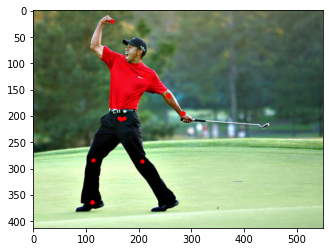

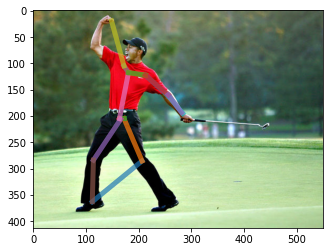

In [15]:
test_image = os.path.join(PROJECT_PATH, 'test_image.jpg')

image, keypoints = predict(model, test_image)
draw_keypoints_on_image(image, keypoints)
draw_skeleton_on_image(image, keypoints)

### Pretrained 모델이랑 비교
- Epoch 1  
  ![epoch1](./images/epoch1.png)
  - 몸의 keypoint들이 제대로 찍혀있지 않음

- Epoch 5
  - 그에 반해 위 결과는 팔꿈치 하나랑 발 하나를 제외하고는 꽤 잘 나옴

[SimpleBaseline 실험 이동](./0317_simplebaseline.ipynb)